 # Toxic comments classification

 Authored by Elina Yancheva and Vladimir Stoyanov

In [6]:
import pandas as pd
import re
import string

import spacy
import numpy as np
from collections import defaultdict
import re
from typing import List, Dict, Set, Tuple
import json

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer

from transformers import AutoModel
import os

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
)

from tqdm import tqdm
tqdm.pandas()

# run python -m spacy download en_core_web_sm
pd.options.display.max_colwidth = 100


/home/stv4sf/Documents/Other/toxic-comments-classification/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [8]:
train.head(n=10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the tools well. · talk """,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or ...",0,0,0,0,0,0
8,00037261f536c51d,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything i...",0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contrary to those of DuLithgow,0,0,0,0,0,0


In [9]:
test.head(n=10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofu...
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can on..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such edits are considered vandalism and quickly undone....
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. \n The correct number lies between 10 000 to 15 00..."
9,00026d1092fe71cc,"== Double Redirects == \n\n When fixing double redirects, don't just blank the outer one, you ne..."


In [10]:
print("Train data shape: ", train.shape)
print("Test data shape: ", test.shape)

Train data shape:  (159571, 8)
Test data shape:  (153164, 2)


 # Data Preparation

 ## Noise Removal

In [11]:
def is_url_in_text(text):
    return ("http" or "www") in text


train["url_in_text"] = train["comment_text"].apply(is_url_in_text)
display(train[train["url_in_text"]].head(n=10)[["comment_text", "url_in_text"]])


def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)


train["comment_text"] = train["comment_text"].apply(remove_URL)
print("After link removal")
display(train[train["url_in_text"]].head(n=10)[["comment_text", "url_in_text"]])
train.drop(columns=["url_in_text"], inplace=True)

string_with_http = """
This is a string with a url: https://www.kaggle.com 
This is another url: glued_text_http://www.google.com and some more text
This is not http but \nwww.google.com this was it
"""
print(remove_URL(string_with_http))

,comment_text,url_in_text
22,"""\n\n Snowflakes are NOT always symmetrical! \n\nUnder Geometry it is stated that """"A snowflake ...",True
33,I was able to post the above list so quickly because I already had it in a text file in my hard ...,True
73,"""\n Ambiguous ? \nSo Mabuska Irish can mean more than one thing ? I will qoute you on that .Than...",True
91,Transliteration of Russian place names\nIn writing about Moscow Metro for the Malayalam Wikipedi...,True
101,Check the following websites:\n\nhttp://www.iranchamber.com/personalities/farabi/farabi.php\nhtt...,True
117,Also see this if you cant trust Murkoth Ramunni\nhttp://books.google.com/books?id=HHev0U1GfpEC&p...,True
123,Should say something about his views as an educationalist and socialist political commentator.\n...,True
188,George W. Bush approval rating graph \n\nhttp://upload.wikimedia.org/wikipedia/commons/1/10/Geor...,True
217,And check this out: http://www.cla.purdue.edu/blackmon/102cs2001/critical.html#bio,True
228,http://www.users.bigpond.com/MONTDALE/page8.html Heritage from village Κρανιώνας in macedonian ...,True


After link removal


,comment_text,url_in_text
22,"""\n\n Snowflakes are NOT always symmetrical! \n\nUnder Geometry it is stated that """"A snowflake ...",True
33,I was able to post the above list so quickly because I already had it in a text file in my hard ...,True
73,"""\n Ambiguous ? \nSo Mabuska Irish can mean more than one thing ? I will qoute you on that .Than...",True
91,Transliteration of Russian place names\nIn writing about Moscow Metro for the Malayalam Wikipedi...,True
101,Check the following websites:\n\n\n\n,True
117,Also see this if you cant trust Murkoth Ramunni\n,True
123,Should say something about his views as an educationalist and socialist political commentator.\n...,True
188,George W. Bush approval rating graph \n\n\n\nThe circle for the September 11th attacks looks too...,True
217,And check this out:,True
228,Heritage from village Κρανιώνας in macedonian Дреновени. Sources claim that the village was pu...,True



This is a string with a url:  
This is another url: glued_text_ and some more text
This is not http but 
 this was it



In [12]:
def is_email_in_text(text):
    return re.match(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", text) is not None


def remove_email(text):
    return re.sub(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", "", text)

train["email_in_text"] = train["comment_text"].apply(is_email_in_text)
display(train[train["email_in_text"]].head(n=10)[["comment_text", "email_in_text"]])

train["comment_text"] = train["comment_text"].apply(remove_email)
train.drop(columns=["email_in_text"], inplace=True)

,comment_text,email_in_text
130194,hyper_individualist@yahoo.com,True


In [13]:
def remove_non_ascii(text):
    return "".join([x for x in text if x in string.printable])

train["comment_text"] = train["comment_text"].apply(remove_non_ascii)


 Comments often contain slang and abbreviations so it's important to "translate" these terms

In [14]:
def clean_text(text):
    """
    Clean text by replacing slang, acronyms, and abbreviations with their full forms

    Args:
        text (str or float/int): Input text to clean. Will handle NaN/None values

    Returns:
        str: Cleaned text with replacements
    """
    # Handle non-string inputs (like NaN, None, or numeric values)
    if not isinstance(text, str):
        return text

    # regex patterns for each dictionary
    patterns = {
        "typos_slang": re.compile(
            r"(?<!\w)("
            + "|".join(re.escape(key) for key in typos_slang.keys())
            + r")(?!\w)"
        ),
        "acronyms": re.compile(
            r"(?<!\w)("
            + "|".join(re.escape(key) for key in acronyms.keys())
            + r")(?!\w)"
        ),
        "abbreviations": re.compile(
            r"(?<!\w)("
            + "|".join(re.escape(key) for key in abbreviations.keys())
            + r")(?!\w)"
        ),
    }

    text = patterns["typos_slang"].sub(lambda x: typos_slang[x.group()], text)
    text = patterns["acronyms"].sub(lambda x: acronyms[x.group()], text)
    text = patterns["abbreviations"].sub(lambda x: abbreviations[x.group()], text)

    return text


typos_slang = {
    "w/e": "whatever",
    "usagov": "usa government",
    "recentlu": "recently",
    "ph0tos": "photos",
    "amirite": "am i right",
    "exp0sed": "exposed",
    "<3": "love",
    "luv": "love",
    "amageddon": "armageddon",
    "trfc": "traffic",
    "16yr": "16 year",
}


acronyms = {"2mw": "tomorrow"}


abbreviations = {
    "$": " dollar ",
    "€": " euro ",
    "4ao": "for adults only",
    "a.m": "before midday",
    "a3": "anytime anywhere anyplace",
    "aamof": "as a matter of fact",
    "acct": "account",
    "adih": "another day in hell",
    "afaic": "as far as i am concerned",
    "afaict": "as far as i can tell",
    "afaik": "as far as i know",
    "afair": "as far as i remember",
    "afk": "away from keyboard",
    "app": "application",
    "approx": "approximately",
    "apps": "applications",
    "asap": "as soon as possible",
    "asl": "age, sex, location",
    "atk": "at the keyboard",
    "ave.": "avenue",
    "aymm": "are you my mother",
    "ayor": "at your own risk",
    "b&b": "bed and breakfast",
    "b+b": "bed and breakfast",
    "b.c": "before christ",
    "b2b": "business to business",
    "b2c": "business to customer",
    "b4": "before",
    "b4n": "bye for now",
    "b@u": "back at you",
    "bae": "before anyone else",
    "bak": "back at keyboard",
    "bbbg": "bye bye be good",
    "bbc": "british broadcasting corporation",
    "bbias": "be back in a second",
    "bbl": "be back later",
    "bbs": "be back soon",
    "be4": "before",
    "bfn": "bye for now",
    "blvd": "boulevard",
    "bout": "about",
    "brb": "be right back",
    "bros": "brothers",
    "brt": "be right there",
    "bsaaw": "big smile and a wink",
    "btw": "by the way",
    "bwl": "bursting with laughter",
    "c/o": "care of",
    "cet": "central european time",
    "cf": "compare",
    "cia": "central intelligence agency",
    "csl": "can not stop laughing",
    "cu": "see you",
    "cul8r": "see you later",
    "cv": "curriculum vitae",
    "cwot": "complete waste of time",
    "cya": "see you",
    "cyt": "see you tomorrow",
    "dae": "does anyone else",
    "dbmib": "do not bother me i am busy",
    "diy": "do it yourself",
    "dm": "direct message",
    "dwh": "during work hours",
    "e123": "easy as one two three",
    "eet": "eastern european time",
    "eg": "example",
    "embm": "early morning business meeting",
    "encl": "enclosed",
    "encl.": "enclosed",
    "etc": "and so on",
    "faq": "frequently asked questions",
    "fawc": "for anyone who cares",
    "fb": "facebook",
    "fc": "fingers crossed",
    "fig": "figure",
    "fimh": "forever in my heart",
    "ft.": "feet",
    "ft": "featuring",
    "ftl": "for the loss",
    "ftw": "for the win",
    "fwiw": "for what it is worth",
    "fyi": "for your information",
    "g9": "genius",
    "gahoy": "get a hold of yourself",
    "gal": "get a life",
    "gcse": "general certificate of secondary education",
    "gfn": "gone for now",
    "gg": "good game",
    "gl": "good luck",
    "glhf": "good luck have fun",
    "gmt": "greenwich mean time",
    "gmta": "great minds think alike",
    "gn": "good night",
    "g.o.a.t": "greatest of all time",
    "goat": "greatest of all time",
    "goi": "get over it",
    "gps": "global positioning system",
    "gr8": "great",
    "gratz": "congratulations",
    "gyal": "girl",
    "h&c": "hot and cold",
    "hp": "horsepower",
    "hr": "hour",
    "hrh": "his royal highness",
    "ht": "height",
    "ibrb": "i will be right back",
    "ic": "i see",
    "icq": "i seek you",
    "icymi": "in case you missed it",
    "idc": "i do not care",
    "idgadf": "i do not give a damn fuck",
    "idgaf": "i do not give a fuck",
    "idk": "i do not know",
    "ie": "that is",
    "i.e": "that is",
    "ifyp": "i feel your pain",
    "IG": "instagram",
    "iirc": "if i remember correctly",
    "ilu": "i love you",
    "ily": "i love you",
    "imho": "in my humble opinion",
    "imo": "in my opinion",
    "imu": "i miss you",
    "iow": "in other words",
    "irl": "in real life",
    "j4f": "just for fun",
    "jic": "just in case",
    "jk": "just kidding",
    "jsyk": "just so you know",
    "l8r": "later",
    "lb": "pound",
    "lbs": "pounds",
    "ldr": "long distance relationship",
    "lmao": "laugh my ass off",
    "lmfao": "laugh my fucking ass off",
    "lol": "laughing out loud",
    "ltd": "limited",
    "ltns": "long time no see",
    "m8": "mate",
    "mf": "motherfucker",
    "mfs": "motherfuckers",
    "mfw": "my face when",
    "mofo": "motherfucker",
    "mph": "miles per hour",
    "mr": "mister",
    "mrw": "my reaction when",
    "ms": "miss",
    "mte": "my thoughts exactly",
    "nagi": "not a good idea",
    "nbc": "national broadcasting company",
    "nbd": "not big deal",
    "nfs": "not for sale",
    "ngl": "not going to lie",
    "nhs": "national health service",
    "nrn": "no reply necessary",
    "nsfl": "not safe for life",
    "nsfw": "not safe for work",
    "nth": "nice to have",
    "nvr": "never",
    "nyc": "new york city",
    "oc": "original content",
    "og": "original",
    "ohp": "overhead projector",
    "oic": "oh i see",
    "omdb": "over my dead body",
    "omg": "oh my god",
    "omw": "on my way",
    "p.a": "per annum",
    "p.m": "after midday",
    "pm": "prime minister",
    "poc": "people of color",
    "pov": "point of view",
    "pp": "pages",
    "ppl": "people",
    "prw": "parents are watching",
    "ps": "postscript",
    "pt": "point",
    "ptb": "please text back",
    "pto": "please turn over",
    "qpsa": "what happens",  # "que pasa",
    "ratchet": "rude",
    "rbtl": "read between the lines",
    "rlrt": "real life retweet",
    "rofl": "rolling on the floor laughing",
    "roflol": "rolling on the floor laughing out loud",
    "rotflmao": "rolling on the floor laughing my ass off",
    "rt": "retweet",
    "ruok": "are you ok",
    "sfw": "safe for work",
    "sk8": "skate",
    "smh": "shake my head",
    "sq": "square",
    "srsly": "seriously",
    "ssdd": "same stuff different day",
    "tbh": "to be honest",
    "tbs": "tablespooful",
    "tbsp": "tablespooful",
    "tfw": "that feeling when",
    "thks": "thank you",
    "tho": "though",
    "thx": "thank you",
    "tia": "thanks in advance",
    "til": "today i learned",
    "tl;dr": "too long i did not read",
    "tldr": "too long i did not read",
    "tmb": "tweet me back",
    "tntl": "trying not to laugh",
    "ttyl": "talk to you later",
    "u": "you",
    "u2": "you too",
    "u4e": "yours for ever",
    "utc": "coordinated universal time",
    "w/": "with",
    "w/o": "without",
    "w8": "wait",
    "wassup": "what is up",
    "wb": "welcome back",
    "wtf": "what the fuck",
    "wtg": "way to go",
    "wtpa": "where the party at",
    "wuf": "where are you from",
    "wuzup": "what is up",
    "wywh": "wish you were here",
    "yd": "yard",
    "ygtr": "you got that right",
    "ynk": "you never know",
    "zzz": "sleeping bored and tired",
}

text = """
"omw 2mw w/ bae tbh idk what's gonna happen l8r <3"
            "gr8 job tbh, imo ur the best!" 42 
"""

print(f"Manual text cleaning demo: \n before: {text}\n after: {clean_text(text)}")

train["comment_text"] = train["comment_text"].apply(clean_text)


Manual text cleaning demo: 
 before: 
"omw 2mw w/ bae tbh idk what's gonna happen l8r <3"
            "gr8 job tbh, imo ur the best!" 42 

 after: 
"on my way tomorrow with before anyone else to be honest i do not know what's gonna happen later love"
            "great job to be honest, in my opinion ur the best!" 42 



 # Data analysis

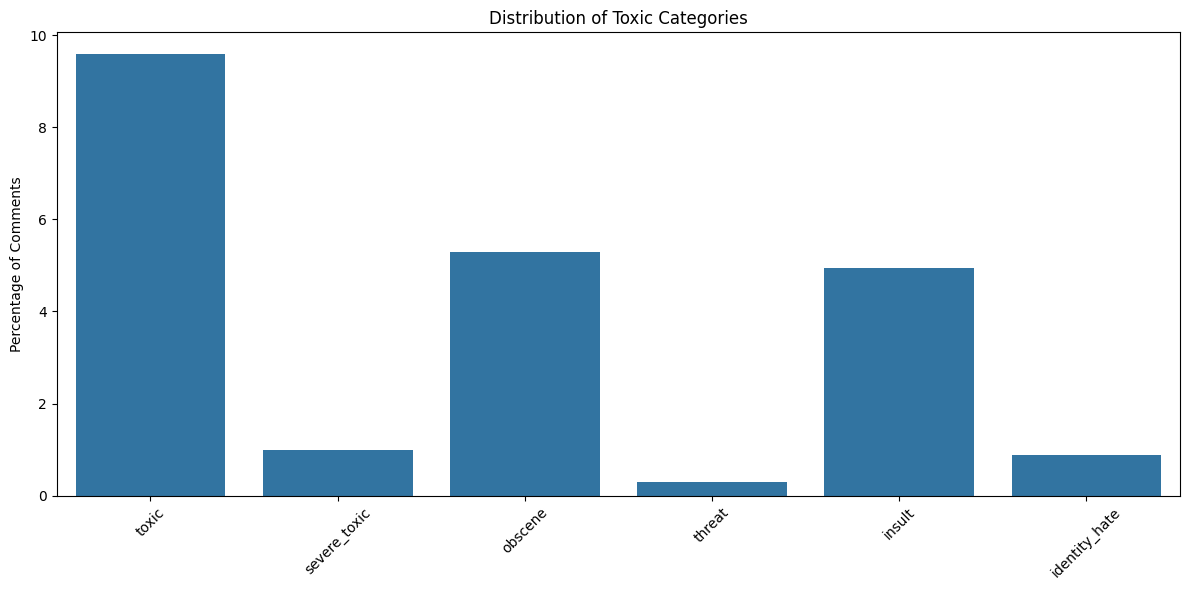

In [15]:
# Analyze the distribution of different toxic categories
def plot_category_distribution(df):
    categories = [
        "toxic",
        "severe_toxic",
        "obscene",
        "threat",
        "insult",
        "identity_hate",
    ]
    plt.figure(figsize=(12, 6))

    percentages = [(df[category].sum() / len(df)) * 100 for category in categories]

    sns.barplot(x=categories, y=percentages)
    plt.title("Distribution of Toxic Categories")
    plt.ylabel("Percentage of Comments")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_category_distribution(train)


 ## Identity processing

In [17]:
class IdentityProcessor:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        self.identity_terms = self._initialize_identity_terms()
        self.context_window = 5

        # Compile regex patterns for identity terms
        self.identity_patterns = self._compile_identity_patterns()

    def _initialize_identity_terms(self) -> Dict[str, Set[str]]:
        """Initialize dictionaries of identity-related terms by category."""
        return {
            "gender": {
                "woman",
                "man",
                "transgender",
                "girl",
                "boy",
                "female",
                "male",
                "lgbt",
                "gay",
                "lesbian",
                "bisexual",
                "queer",
                "straight",
                "homosexual",
            },
            "race_ethnicity": {
                "black",
                "white",
                "asian",
                "hispanic",
                "latino",
                "latina",
                "native",
                "african",
                "european",
                "middle eastern",
                "jewish",
                "muslim",
                "islamic",
            },
            "religion": {
                "christian",
                "muslim",
                "jewish",
                "hindu",
                "buddhist",
                "atheist",
                "catholic",
                "protestant",
                "sikh",
                "religious",
                "secular",
            },
            "age": {
                "young",
                "old",
                "elderly",
                "teen",
                "teenage",
                "adult",
                "senior",
                "millennial",
                "boomer",
                "generation",
            },
            "disability": {
                "disabled",
                "handicapped",
                "blind",
                "deaf",
                "autistic",
                "wheelchair",
            },
        }

    def _compile_identity_patterns(self) -> Dict[str, re.Pattern]:
        """Compile regex patterns for identity terms."""
        patterns = {}
        for category, terms in self.identity_terms.items():
            pattern = r"\b(" + "|".join(re.escape(term) for term in terms) + r")\b"
            patterns[category] = re.compile(pattern, re.IGNORECASE)
        return patterns

    def process_text(self, text: str) -> Dict:
        """
        Process a single text to identify and analyze identity-related content.

        Returns:
            Dict containing identity analysis results
        """
        # Process text with spaCy
        doc = self.nlp(text)

        results = {
            "identity_mentions": defaultdict(list),
            "identity_contexts": defaultdict(list),
            "named_entities": [],
            "overall_sentiment": self._analyze_sentiment(doc),
            "identity_term_count": 0,
        }

        # Analyze identity terms
        for category, pattern in self.identity_patterns.items():
            matches = pattern.finditer(text.lower())
            for match in matches:
                term = match.group()
                start_idx = match.start()
                context = self._extract_context(text, start_idx, self.context_window)

                results["identity_mentions"][category].append(
                    {
                        "term": term,
                        "position": start_idx,
                        "context": context,
                        "context_sentiment": self._analyze_context_sentiment(context),
                    }
                )
                results["identity_term_count"] += 1

        # Extract named entities that might be identity-related
        for ent in doc.ents:
            if ent.label_ in [
                "PERSON",
                "NORP",
                "ORG",
            ]:  # NORP: Nationalities, religious or political groups
                results["named_entities"].append(
                    {
                        "text": ent.text,
                        "label": ent.label_,
                        "context": self._extract_context(
                            text, ent.start_char, self.context_window
                        ),
                    }
                )

        return results

    def _extract_context(self, text: str, position: int, window_size: int) -> str:
        """Extract context around a specific position in text."""
        words = text.split()
        word_position = len(text[:position].split())
        start = max(0, word_position - window_size)
        end = min(len(words), word_position + window_size + 1)
        return " ".join(words[start:end])

    def _analyze_sentiment(self, doc) -> float:
        """Basic sentiment analysis of spaCy doc."""
        # This is a placeholder - WIP - a more sophisticated sentiment analyzer
        return doc.sentiment

    def _analyze_context_sentiment(self, context: str) -> float:
        """Analyze sentiment of context around identity terms."""
        doc = self.nlp(context)
        return doc.sentiment

    def process_dataframe(
        self, df: pd.DataFrame, text_column: str = "comment_text"
    ) -> pd.DataFrame:
        """
        Process entire dataframe and add identity-related features.

        Args:
            df: Input dataframe
            text_column: Name of column containing text to analyze

        Returns:
            DataFrame with additional identity-related columns
        """
        processed_df = df.copy()

        results = processed_df[text_column].apply(self.process_text)

        # Extract features from results 
        processed_df.loc[:, "identity_term_count"] = results.apply(
            lambda x: x["identity_term_count"]
        )
        processed_df.loc[:, "has_identity_terms"] = (
            processed_df["identity_term_count"] > 0
        )

        # category-specific columns
        for category in self.identity_terms.keys():
            processed_df.loc[:, f"{category}_mentions"] = results.apply(
                lambda x: len(x["identity_mentions"][category])
            )

        # context sentiment features
        processed_df.loc[:, "identity_context_sentiment"] = results.apply(
            lambda x: np.mean(
                [
                    mention["context_sentiment"]
                    for mentions in x["identity_mentions"].values()
                    for mention in mentions
                ]
            )
            if x["identity_term_count"] > 0
            else 0
        )

        return processed_df

    def get_identity_term_statistics(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Generate statistics about identity term usage in the dataset.

        Returns:
            DataFrame with identity term statistics
        """
        stats = []
        for category, terms in self.identity_terms.items():
            for term in terms:
                term_count = df["comment_text"].str.count(term).sum()
                toxic_mentions = (
                    df[df["toxic"] == 1]["comment_text"].str.count(term).sum()
                )

                stats.append(
                    {
                        "category": category,
                        "term": term,
                        "total_mentions": term_count,
                        "toxic_mentions": toxic_mentions,
                        "toxic_ratio": toxic_mentions / term_count
                        if term_count > 0
                        else 0,
                    }
                )

        return pd.DataFrame(stats)

    def save_processed_data(
        self, processed_df, identity_stats, output_dir="processed_data"
    ):
        """
        Save processed features and statistics to files.

        Args:
            processed_df: Processed DataFrame with identity features
            identity_stats: DataFrame with identity term statistics
            output_dir: Directory to save the files
        """
        import os

        os.makedirs(output_dir, exist_ok=True)

        # Save features 
        features_csv = os.path.join(output_dir, "identity_features.csv")
        features_pkl = os.path.join(output_dir, "identity_features.pkl")
        processed_df.to_csv(features_csv, index=False)
        processed_df.to_pickle(features_pkl)

        # Save statistics 
        stats_csv = os.path.join(output_dir, "identity_statistics.csv")
        stats_pkl = os.path.join(output_dir, "identity_statistics.pkl")
        identity_stats.to_csv(stats_csv, index=False)
        identity_stats.to_pickle(stats_pkl)

        print("Saved processed features to:")
        print(f"- CSV: {features_csv}")
        print(f"- Pickle: {features_pkl}")
        print("\nSaved identity statistics to:")
        print(f"- CSV: {stats_csv}")
        print(f"- Pickle: {stats_pkl}")

    @staticmethod
    def load_processed_data(input_dir="processed_data"):
        """
        Load processed features and statistics from files.

        Args:
            input_dir: Directory containing the saved files

        Returns:
            tuple: (processed_features_df, identity_statistics_df)
        """
        import os

        features_pkl = os.path.join(input_dir, "identity_features.pkl")
        stats_pkl = os.path.join(input_dir, "identity_statistics.pkl")

        if not os.path.exists(features_pkl) or not os.path.exists(stats_pkl):
            raise FileNotFoundError(f"Processed data files not found in {input_dir}")

        # Load the data
        processed_df = pd.read_pickle(features_pkl)
        identity_stats = pd.read_pickle(stats_pkl)

        print(f"Loaded processed features with shape: {processed_df.shape}")
        print(f"Loaded identity statistics with shape: {identity_stats.shape}")

        return processed_df, identity_stats


processor = IdentityProcessor()
train_processed = processor.process_dataframe(train)
identity_stats = processor.get_identity_term_statistics(train)

processor.save_processed_data(
    train_processed, identity_stats, output_dir="processed_identity_data"
)

loaded_features, loaded_stats = IdentityProcessor.load_processed_data(
    input_dir="processed_identity_data"
)


Saved processed features to:
- CSV: processed_identity_data/identity_features.csv
- Pickle: processed_identity_data/identity_features.pkl

Saved identity statistics to:
- CSV: processed_identity_data/identity_statistics.csv
- Pickle: processed_identity_data/identity_statistics.pkl
Loaded processed features with shape: (159571, 16)
Loaded identity statistics with shape: (54, 5)


 # Text Normalization

 1. Identity-Aware Normalization:

 - Preserves identity terms and their case

 - Custom stopword list that excludes identity terms

 - Tracks context around identity mentions





 2. Polarity and Negation:

 - Handles negations ("not", "never", etc.)

 - Marks negated terms

 - Tracks negation context around identity terms





 3. Feature Generation:

 - Creates polarity features

 - Tracks positive/negative contexts

 - Preserves important linguistic markers

In [18]:
class TextNormalizer:
    def __init__(self, identity_terms: Dict[str, Set[str]]):
        """Initialize text normalizer with identity term awareness."""
        nltk.download("punkt")
        nltk.download("stopwords")

        self.identity_terms = identity_terms
        self.all_identity_terms = {
            term.lower() for terms in identity_terms.values() for term in terms
        }
        self.stop_words = self._create_custom_stopwords()

        # Negation patterns
        self.negation_patterns = re.compile(
            r"\b(?:not|no|never|none|neither|nowhere|nobody|nothing|n\'t|cannot|"
            r"can\'?t|won\'?t|wouldn\'?t|shouldn\'?t|couldn\'?t|don\'?t|"
            r"doesn\'?t|isn\'?t|aren\'?t|ain\'?t)\b",
            re.IGNORECASE,
        )

        # Define scope terminators - punctuation that ends a negation context
        self.scope_terminators = {
            ".",
            "!",
            "?",
            ",",
            ";",
            "but",
            "however",
            "nevertheless",
            "yet",
            "although",
            "though",
            "still",
            "instead",
        }

        # Define words that shouldn't be negated
        self.non_negatable = {
            "i",
            "am",
            "is",
            "are",
            "was",
            "were",
            "be",
            "been",
            "being",
            "have",
            "has",
            "had",
            "do",
            "does",
            "did",
            "can",
            "could",
            "will",
            "would",
            "shall",
            "should",
            "may",
            "might",
            "must",
            "the",
            "a",
            "an",
            "and",
            "or",
            "but",
            "in",
            "on",
            "at",
            "to",
        }

    def _create_custom_stopwords(self) -> Set[str]:
        """Create custom stopword list that preserves identity terms."""
        standard_stops = set(stopwords.words("english"))
        return {
            word
            for word in standard_stops
            if word.lower() not in self.all_identity_terms
        }
        # e.g man - shouldn't be avoided as stopword

    def normalize_text(self, text: str, preserve_case: bool = True) -> str:
        """Normalize text with improved negation handling."""
        if not isinstance(text, str):
            return ""

        tokens = word_tokenize(text)
        normalized_tokens = []
        in_negation_context = False
        words_since_negation = 0
        max_negation_scope = 3  # Maximum words to be negated after a negation term

        for i, token in enumerate(tokens):
            lower_token = token.lower()

            # Reset negation context if we hit a scope terminator
            if lower_token in self.scope_terminators:
                in_negation_context = False
                words_since_negation = 0
                normalized_tokens.append(token)
                continue

            # Check for negation - double negations are handled correctly
            if self.negation_patterns.match(token):
                in_negation_context = True
                words_since_negation = 0
                normalized_tokens.append(token)
                continue

            # Preserve identity terms
            if lower_token in self.all_identity_terms:
                normalized_tokens.append(token)  # Preserve original case
                continue

            if not preserve_case:
                token = lower_token

            # Add negation marker if in valid negation context
            # e.g "not good" -> "NOT_good"
            if (
                in_negation_context
                and words_since_negation < max_negation_scope
                and lower_token not in self.non_negatable
                and lower_token not in self.stop_words
            ):
                token = f"NOT_{token}"
                words_since_negation += 1

            normalized_tokens.append(token)

            # Update negation tracking
            if in_negation_context:
                words_since_negation += 1
                if words_since_negation >= max_negation_scope:
                    in_negation_context = False

        return " ".join(normalized_tokens)

    def create_polarity_features(self, text: str) -> Dict[str, float]:
        """Create enhanced polarity features for text."""
        if not isinstance(text, str):
            return {
                "negation_count": 0,
                "identity_in_negation": 0,
                "identity_positive_context": 0,
                "identity_negative_context": 0,
            }

        phrases = re.split("[.!?]", text)
        features = {
            "negation_count": 0,
            "identity_in_negation": 0,
            "identity_positive_context": 0,
            "identity_negative_context": 0,
        }

        # sentiment word lists
        neg_words = {
            "bad",
            "hate",
            "wrong",
            "stupid",
            "idiot",
            "terrible",
            "awful",
            "horrible",
            "disgusting",
            "pathetic",
            "worthless",
            "evil",
            "angry",
            "furious",
            "offensive",
            "ignorant",
            "cruel",
            "negative",
            "poor",
            "worst",
            "weak",
            "reject",
            "failure",
            "fail",
            "suck",
            "inferior",
            "incompetent",
        }

        pos_words = {
            "good",
            "love",
            "great",
            "nice",
            "kind",
            "wonderful",
            "excellent",
            "amazing",
            "fantastic",
            "brilliant",
            "beautiful",
            "helpful",
            "friendly",
            "positive",
            "respect",
            "support",
            "appreciate",
            "superior",
            "competent",
            "capable",
            "skilled",
            "talented",
        }

        for phrase in phrases:
            if not phrase.strip():
                continue

            has_negation = bool(self.negation_patterns.search(phrase.lower()))
            words = [w.lower() for w in word_tokenize(phrase)]

            if has_negation:
                features["negation_count"] += 1

            # Check for identity terms in the phrase
            phrase_lower = phrase.lower()
            for term in self.all_identity_terms:
                if term in phrase_lower:
                    # Find the approximate position of the term
                    term_found = False
                    for i, word in enumerate(words):
                        if term in word:
                            # Found an identity term, now analyze its context
                            term_found = True
                            start = max(0, i - 5)  # 5 words before
                            end = min(len(words), i + 6)  # 5 words after
                            context = words[start:end]

                            if has_negation:
                                features["identity_in_negation"] += 1

                            # Check context sentiment
                            if any(word in neg_words for word in context):
                                features["identity_negative_context"] += 1
                            if any(word in pos_words for word in context):
                                features["identity_positive_context"] += 1

                            break

                    # If we didn't find the term in individual words,
                    # but we know it's in the phrase, check for compound terms
                    if not term_found and " " in term:
                        if has_negation:
                            features["identity_in_negation"] += 1
                        # For compound terms, analyze the whole phrase
                        if any(word in neg_words for word in words):
                            features["identity_negative_context"] += 1
                        if any(word in pos_words for word in words):
                            features["identity_positive_context"] += 1

        return features

    tqdm.pandas()

    def normalize_dataframe(
        self, df: pd.DataFrame, text_column: str = "comment_text"
    ) -> pd.DataFrame:
        """Apply normalization to entire dataframe."""
        print("Normalizing texts...")
        df["normalized_text"] = df[text_column].progress_apply(self.normalize_text)

        print("Extracting polarity features...")
        polarity_features = df[text_column].progress_apply(
            self.create_polarity_features
        )

        for feature in [
            "negation_count",
            "identity_in_negation",
            "identity_positive_context",
            "identity_negative_context",
        ]:
            df[feature] = polarity_features.apply(lambda x: x[feature])

        return df



 Example

In [19]:
# Download required NLTK data
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

sample_comments = pd.DataFrame(
    {
        "comment_text": [
            "I hate how gay people always make everything about being gay. They should just keep quiet.",
            "Mr. Smith is a great teacher. He's not discriminating against any students.",
            "I love how diverse our community is. Muslims, Christians, and Jews all working together.",
            "Being transgender is NOT a mental illness. Stop spreading hate!",
        ]
    }
)

identity_terms = {
    "gender": {"woman", "man", "transgender", "gay"},
    "religion": {"muslim", "christian", "jew"},
}

normalizer = TextNormalizer(identity_terms)

print("=== Text Normalization Examples ===\n")
for idx, comment in enumerate(sample_comments["comment_text"], 1):
    print(f"\nExample {idx}:")
    print(f"Original: {comment}")
    print(f"Normalized: {normalizer.normalize_text(comment)}")
    print(
        "\nPolarity Features:",
        json.dumps(normalizer.create_polarity_features(comment), indent=2),
    )
    print("\nSentence Tokenization:", sent_tokenize(comment))
    print("-" * 80)

normalized_df = normalizer.normalize_dataframe(sample_comments)
print("\n=== Full DataFrame Processing ===")
print("\nColumns in processed dataframe:")
print(normalized_df.columns.tolist())
print("\nSample of processed data:")
print(normalized_df.head(2).to_string())


[nltk_data] Downloading package punkt to /home/stv4sf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/stv4sf/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/stv4sf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/stv4sf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/stv4sf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=== Text Normalization Examples ===


Example 1:
Original: I hate how gay people always make everything about being gay. They should just keep quiet.
Normalized: I hate how gay people always make everything about being gay . They should just keep quiet .

Polarity Features: {
  "negation_count": 0,
  "identity_in_negation": 0,
  "identity_positive_context": 0,
  "identity_negative_context": 1
}

Sentence Tokenization: ['I hate how gay people always make everything about being gay.', 'They should just keep quiet.']
--------------------------------------------------------------------------------

Example 2:
Original: Mr. Smith is a great teacher. He's not discriminating against any students.
Normalized: Mr. Smith is a great teacher . He 's not NOT_discriminating against any students .

Polarity Features: {
  "negation_count": 1,
  "identity_in_negation": 0,
  "identity_positive_context": 0,
  "identity_negative_context": 0
}

Sentence Tokenization: ['Mr. Smith is a great teacher.', "He's

100%|██████████| 4/4 [00:00<00:00, 3462.79it/s]


Extracting polarity features...


100%|██████████| 4/4 [00:00<00:00, 4214.32it/s]


=== Full DataFrame Processing ===

Columns in processed dataframe:
['comment_text', 'normalized_text', 'negation_count', 'identity_in_negation', 'identity_positive_context', 'identity_negative_context']

Sample of processed data:
                                                                                 comment_text                                                                               normalized_text  negation_count  identity_in_negation  identity_positive_context  identity_negative_context
0  I hate how gay people always make everything about being gay. They should just keep quiet.  I hate how gay people always make everything about being gay . They should just keep quiet .               0                     0                          0                          1
1                 Mr. Smith is a great teacher. He's not discriminating against any students.            Mr. Smith is a great teacher . He 's not NOT_discriminating against any students .               1      

Example 1:


Original: I hate how gay people always make everything about being gay. They should just keep quiet.


Normalized: I hate how gay people always make everything about being gay . They should just keep quiet.


```json
Polarity Features: {
  "negation_count": 0,
  "identity_in_negation": 0,
  "identity_positive_context": 0,
  "identity_negative_context": 1
}
```

Sentence Tokenization: ['I hate how gay people always make everything about being gay.', 'They should just keep quiet.']
--------------------------------------------------------------------------------


Example 2:


Original: Mr. Smith is a great teacher. He's not discriminating against any students.


Normalized: Mr. Smith is a great teacher . He 's not NOT_discriminating against any students .


```json
Polarity Features: {
  "negation_count": 1,
  "identity_in_negation": 0,
  "identity_positive_context": 0,
  "identity_negative_context": 0
}
```

In [15]:
nltk.download("punkt")
nltk.download("stopwords")

normalizer = TextNormalizer(processor.identity_terms)

# Apply normalization to the actual training data
print("Normalizing training data...")
train_normalized = normalizer.normalize_dataframe(train_processed)

# Look at the new columns we've added
new_columns = set(train_normalized.columns) - set(train_processed.columns)
print("\nNew columns added:")
for col in new_columns:
    print(f"- {col}")

train_normalized.to_pickle("train_normalized.pkl")

# Filter for toxic comments containing identity terms
identity_toxic_comments = train_normalized[
    (train_normalized["toxic"] == 1) & (train_normalized["identity_term_count"] > 0)
].copy()

print(f"\nFound {len(identity_toxic_comments)} toxic comments with identity terms")

print("\nSample of toxic comments with identity terms:")
for i in range(min(5, len(identity_toxic_comments))):
    print(f"\nExample {i + 1}:")
    print(f"Original: {identity_toxic_comments['comment_text'].iloc[i]}")
    print(f"Normalized: {identity_toxic_comments['normalized_text'].iloc[i]}")
    print(
        "Polarity features:",
        {
            k: identity_toxic_comments[k].iloc[i]
            for k in [
                "negation_count",
                "identity_in_negation",
                "identity_positive_context",
                "identity_negative_context",
            ]
        },
    )
    print("-" * 80)


[nltk_data] Downloading package punkt to /home/stv4sf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/stv4sf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/stv4sf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/stv4sf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Normalizing training data...
Normalizing texts...


100%|██████████| 159571/159571 [01:32<00:00, 1725.12it/s]


Extracting polarity features...


100%|██████████| 159571/159571 [01:28<00:00, 1796.04it/s]



New columns added:

Found 2216 toxic comments with identity terms

Sample of toxic comments with identity terms:

Example 1:
Original: You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!
Normalized: You are gay or antisemmitian ? Archangel WHite Tiger Meow ! Greetingshhh ! Uh , there are two ways , why you do erased my comment about WW2 , that holocaust was brutally slaying of Jews and not NOT_gays/

 # Feature Engineering

 1. Linguistic Features:

 - Sentence structure metrics

 - POS tag distributions

 - Dependency parse features

 - Text complexity metrics





 2. Bias-Aware Features:

 - Pattern matching for bias indicators

 - Identity term context analysis

 - Stereotyping pattern detection

 - Group generalization metrics



 3. Text Representation:

 - TF-IDF features

 - Word n-grams

 - Character n-grams

 - Position-aware features

In [16]:
class FeatureEngineer:
    def __init__(self, nlp=None):
        """Initialize the feature engineer with optional spaCy model."""
        self.nlp = nlp if nlp else spacy.load("en_core_web_sm")

        # Initialize vectorizers
        self.word_vectorizer = TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            strip_accents="unicode",
            sublinear_tf=True,
        )

        # Identity-specific patterns
        self.identity_patterns = {
            "targeted_hate": r"(?:all|every|typical|always|these)\s+({identity_term})",
            "stereotyping": r"(?:you|they|these)\s+(?:people|folks|ones)\s+are",
            "us_vs_them": r"(?:these|those|you)\s+(?:people|ones|type)",
            "derogatory": r"stupid|dumb|idiot|moron",
        }

    def extract_linguistic_features(self, doc) -> Dict:
        """Extract linguistic features from spaCy doc."""
        return {
            "sentence_count": len(list(doc.sents)),
            "avg_word_length": np.mean([len(token.text) for token in doc]),
            "verb_count": len([token for token in doc if token.pos_ == "VERB"]),
            "adj_count": len([token for token in doc if token.pos_ == "ADJ"]),
            "pronoun_count": len([token for token in doc if token.pos_ == "PRON"]),
            "capital_ratio": sum(1 for c in doc.text if c.isupper()) / len(doc.text)
            if len(doc.text) > 0
            else 0,
            "has_question": any(token.text == "?" for token in doc),
            "has_exclamation": any(token.text == "!" for token in doc),
            "dependency_distance": self._calculate_dependency_distance(doc),
        }

    def _calculate_dependency_distance(self, doc) -> float:
        """Calculate average dependency distance in parse tree."""
        distances = []
        for token in doc:
            if token.head != token:  # Skip root
                distance = abs(token.i - token.head.i)
                distances.append(distance)
        return np.mean(distances) if distances else 0

    def extract_bias_features(
        self, text: str, identity_terms: Dict[str, Set[str]]
    ) -> Dict:
        """Extract bias-specific features from text."""
        features = {
            "targeted_hate_count": 0,
            "stereotyping_count": 0,
            "us_vs_them_count": 0,
            "derogatory_count": 0,
            "identity_followed_by_negative": 0,
            "identity_preceded_by_all": 0,
        }

        # Flatten identity terms for pattern matching
        all_identity_terms = "|".join(
            term for terms in identity_terms.values() for term in terms
        )

        # Check each pattern
        for pattern_name, pattern in self.identity_patterns.items():
            pattern = pattern.format(identity_term=all_identity_terms)
            matches = re.finditer(pattern, text.lower())
            features[f"{pattern_name}_count"] = sum(1 for _ in matches)

        return features

    def create_embedding_features(self, texts: List[str]) -> np.ndarray:
        """Create TF-IDF features for text."""
        return self.word_vectorizer.fit_transform(texts)

    def process_dataframe(
        self,
        df: pd.DataFrame,
        text_column: str = "normalized_text",
        identity_terms: Dict[str, Set[str]] = None,
    ) -> pd.DataFrame:
        """
        Process entire dataframe to add engineered features efficiently.
        """
        print("Processing linguistic features...")
        docs = list(self.nlp.pipe(df[text_column], batch_size=1000))

        linguistic_features = pd.DataFrame(
            [self.extract_linguistic_features(doc) for doc in docs]
        )

        print("Extracting bias features...")
        # Extract bias features if identity terms provided
        if identity_terms:
            bias_features = pd.DataFrame(
                [
                    self.extract_bias_features(text, identity_terms)
                    for text in df[text_column]
                ]
            )
        else:
            bias_features = pd.DataFrame()

        print("Creating TF-IDF features...")
        # Create TF-IDF features
        tfidf_features = self.create_embedding_features(df[text_column])

        # Convert to dense array for selected top features
        top_features = 100
        dense_features = tfidf_features[:, :top_features].toarray()

        tfidf_df = pd.DataFrame(
            dense_features, columns=[f"tfidf_{i}" for i in range(top_features)]
        )

        all_features = [df, linguistic_features, bias_features, tfidf_df]

        result = pd.concat(all_features, axis=1)

        return result

In [17]:
feature_engineer = FeatureEngineer()

train_features = feature_engineer.process_dataframe(
    train_normalized,
    text_column="normalized_text",
    identity_terms=processor.identity_terms,
)

train_features.to_pickle("train_features.pkl")

new_columns = set(train_features.columns) - set(train_normalized.columns)
print("\nNew engineered features:")
for col in sorted(new_columns):
    print(f"- {col}")

Processing linguistic features...


/home/stv4sf/Documents/Other/toxic-comments-classification/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stv4sf/Documents/Other/toxic-comments-classification/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Extracting bias features...
Creating TF-IDF features...

New engineered features:
- adj_count
- avg_word_length
- capital_ratio
- dependency_distance
- derogatory_count
- has_exclamation
- has_question
- identity_followed_by_negative
- identity_preceded_by_all
- pronoun_count
- sentence_count
- stereotyping_count
- targeted_hate_count
- tfidf_0
- tfidf_1
- tfidf_10
- tfidf_11
- tfidf_12
- tfidf_13
- tfidf_14
- tfidf_15
- tfidf_16
- tfidf_17
- tfidf_18
- tfidf_19
- tfidf_2
- tfidf_20
- tfidf_21
- tfidf_22
- tfidf_23
- tfidf_24
- tfidf_25
- tfidf_26
- tfidf_27
- tfidf_28
- tfidf_29
- tfidf_3
- tfidf_30
- tfidf_31
- tfidf_32
- tfidf_33
- tfidf_34
- tfidf_35
- tfidf_36
- tfidf_37
- tfidf_38
- tfidf_39
- tfidf_4
- tfidf_40
- tfidf_41
- tfidf_42
- tfidf_43
- tfidf_44
- tfidf_45
- tfidf_46
- tfidf_47
- tfidf_48
- tfidf_49
- tfidf_5
- tfidf_50
- tfidf_51
- tfidf_52
- tfidf_53
- tfidf_54
- tfidf_55
- tfidf_56
- tfidf_57
- tfidf_58
- tfidf_59
- tfidf_6
- tfidf_60
- tfidf_61
- tfidf_62
- tfidf_63

In [20]:
class CombinedFeatureExtractor:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")

        self._initialize_patterns()

    def _initialize_patterns(self):
        """Initialize all patterns and word lists."""
        # Toxicity patterns
        self.aggressive_words = {
            "stupid",
            "idiot",
            "dumb",
            "moron",
            "fool",
            "retard",
            "loser",
            "worthless",
            "pathetic",
            "trash",
            "garbage",
        }

        self.hate_patterns = [
            r"go back to",
            r"you people",
            r"you all are",
            r"(hate|despise|can\'t stand) (\w+ )*(people|group|community)",
        ]

        # Bias patterns
        self.stereotype_patterns = [
            r"all of them are",
            r"they always",
            r"these people",
            r"(typical|always|every) \w+ (person|people)",
        ]

        # Emotional words
        self.emotion_words = {
            "anger": {"angry", "furious", "mad", "rage", "hatred"},
            "disgust": {"disgusting", "gross", "revolting", "sick"},
            "fear": {"scared", "terrified", "afraid", "frightened"},
            "joy": {"happy", "excited", "glad", "pleased"},
            "sadness": {"sad", "depressed", "unhappy", "miserable"},
        }

    def extract_basic_features(self, doc) -> Dict[str, float]:
        """Extract basic linguistic features."""
        return {
            "word_count": len(doc),
            "avg_word_length": sum(len(token.text) for token in doc) / len(doc)
            if len(doc) > 0
            else 0,
            "sentence_count": len(list(doc.sents)),
            "uppercase_ratio": sum(1 for c in doc.text if c.isupper()) / len(doc.text)
            if len(doc.text) > 0
            else 0,
            "punctuation_ratio": sum(1 for c in doc.text if c in string.punctuation)
            / len(doc.text)
            if len(doc.text) > 0
            else 0,
        }

    def extract_toxicity_features(self, doc) -> Dict[str, float]:
        """Extract toxicity-specific features."""
        text = doc.text.lower()

        personal_attacks = sum(
            1
            for token in doc
            if token.text.lower() in {"you", "your", "you're"}
            and any(
                child.text.lower() in self.aggressive_words for child in token.children
            )
        )

        hate_count = sum(
            len(re.findall(pattern, text)) for pattern in self.hate_patterns
        )

        aggressive_count = sum(
            1 for token in doc if token.text.lower() in self.aggressive_words
        )

        return {
            "personal_attack_score": personal_attacks / len(doc) if len(doc) > 0 else 0,
            "hate_pattern_count": hate_count,
            "aggressive_word_ratio": aggressive_count / len(doc) if len(doc) > 0 else 0,
        }

    def extract_bias_features(self, doc) -> Dict[str, float]:
        """Extract bias-specific features."""
        text = doc.text.lower()

        stereotype_count = sum(
            len(re.findall(pattern, text)) for pattern in self.stereotype_patterns
        )

        generalization_count = sum(
            1
            for token in doc
            if token.text.lower() in {"all", "every", "always", "never"}
        )

        return {
            "stereotype_pattern_count": stereotype_count,
            "generalization_ratio": generalization_count / len(doc)
            if len(doc) > 0
            else 0,
        }

    def extract_emotion_features(self, doc) -> Dict[str, float]:
        """Extract emotion-related features."""
        text = doc.text.lower()
        emotions = {}

        for emotion, words in self.emotion_words.items():
            count = sum(1 for token in doc if token.text.lower() in words)
            emotions[f"{emotion}_ratio"] = count / len(doc) if len(doc) > 0 else 0

        return emotions

    def extract_syntax_features(self, doc) -> Dict[str, float]:
        """Extract syntax-related features."""
        return {
            "verb_ratio": sum(1 for token in doc if token.pos_ == "VERB") / len(doc)
            if len(doc) > 0
            else 0,
            "adj_ratio": sum(1 for token in doc if token.pos_ == "ADJ") / len(doc)
            if len(doc) > 0
            else 0,
            "adv_ratio": sum(1 for token in doc if token.pos_ == "ADV") / len(doc)
            if len(doc) > 0
            else 0,
            "pronoun_ratio": sum(1 for token in doc if token.pos_ == "PRON") / len(doc)
            if len(doc) > 0
            else 0,
            "imperative_count": sum(
                1 for sent in doc.sents if list(sent)[0].pos_ == "VERB"
            ),
        }

    def process_text(self, text: str) -> Dict[str, float]:
        """Process a single text to extract all features."""
        if not isinstance(text, str) or not text.strip():
            return self._get_empty_features()

        doc = self.nlp(text)

        features = {}
        features.update(self.extract_basic_features(doc))
        features.update(self.extract_toxicity_features(doc))
        features.update(self.extract_bias_features(doc))
        features.update(self.extract_emotion_features(doc))
        features.update(self.extract_syntax_features(doc))

        return features

    def _get_empty_features(self) -> Dict[str, float]:
        """Return a dictionary with zero values for all features."""
        return {
            "word_count": 0,
            "avg_word_length": 0,
            "sentence_count": 0,
            "uppercase_ratio": 0,
            "punctuation_ratio": 0,
            "personal_attack_score": 0,
            "hate_pattern_count": 0,
            "aggressive_word_ratio": 0,
            "stereotype_pattern_count": 0,
            "generalization_ratio": 0,
            "verb_ratio": 0,
            "adj_ratio": 0,
            "adv_ratio": 0,
            "pronoun_ratio": 0,
            "imperative_count": 0,
            "anger_ratio": 0,
            "disgust_ratio": 0,
            "fear_ratio": 0,
            "joy_ratio": 0,
            "sadness_ratio": 0,
        }

    def process_dataframe(
        self, df: pd.DataFrame, text_column: str = "normalized_text"
    ) -> pd.DataFrame:
        """Process entire dataframe to add new features."""
        print("Extracting combined features...")

        new_features = []
        for text in tqdm(df[text_column], desc="Processing texts"):
            features = self.process_text(text)
            new_features.append(features)

        new_features_df = pd.DataFrame(new_features)
        result = pd.concat([df, new_features_df], axis=1)

        return result



In [ ]:
extractor = CombinedFeatureExtractor()

train_features = extractor.process_dataframe(train_normalized)

new_columns = set(train_features.columns) - set(train_normalized.columns)
print("\nNew combined features added:")
for col in sorted(list(new_columns)):
    print(f"- {col}")

print("\nFeature comparison for toxic vs non-toxic comments:")
toxic_example = train_features[train_features["toxic"] == 1].iloc[0]
non_toxic_example = train_features[train_features["toxic"] == 0].iloc[0]

print("\nToxic comment features:")
for col in sorted(new_columns):
    print(f"{col}: {toxic_example[col]:.3f}")

print("\nNon-toxic comment features:")
for col in sorted(new_columns):
    print(f"{col}: {non_toxic_example[col]:.3f}")

# Save the features
train_features.to_pickle("combined_features.pkl")



Evaluating toxic classifier...
Class distribution:
toxic
0    0.904133
1    0.095867
Name: proportion, dtype: float64

Results for toxic:
ROC-AUC Score: 0.817

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     28859
           1       0.90      0.04      0.08      3056

    accuracy                           0.91     31915
   macro avg       0.90      0.52      0.52     31915
weighted avg       0.91      0.91      0.87     31915



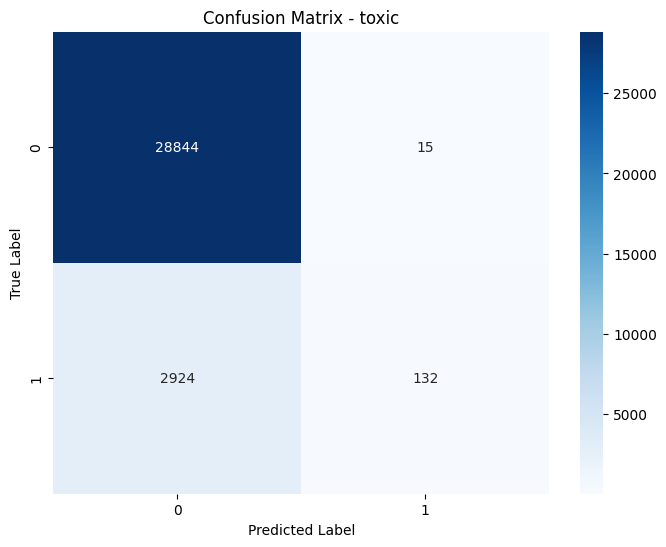

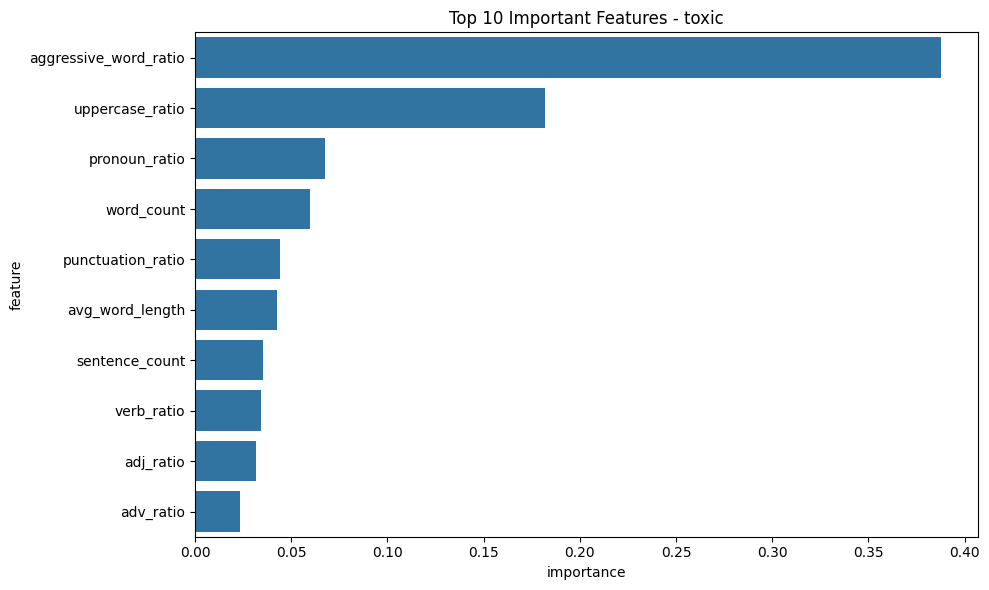


Evaluating severe_toxic classifier...
Class distribution:
severe_toxic
0    0.99002
1    0.00998
Name: proportion, dtype: float64

Results for severe_toxic:
ROC-AUC Score: 0.865

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     31594
           1       0.06      0.59      0.11       321

    accuracy                           0.91     31915
   macro avg       0.53      0.75      0.53     31915
weighted avg       0.99      0.91      0.94     31915



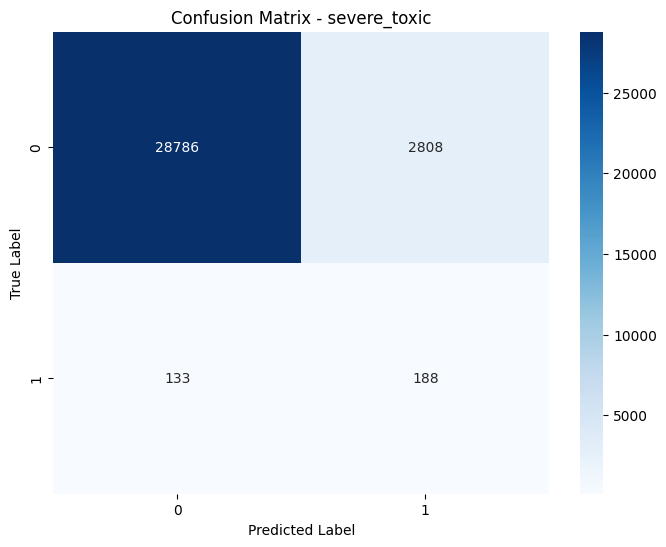

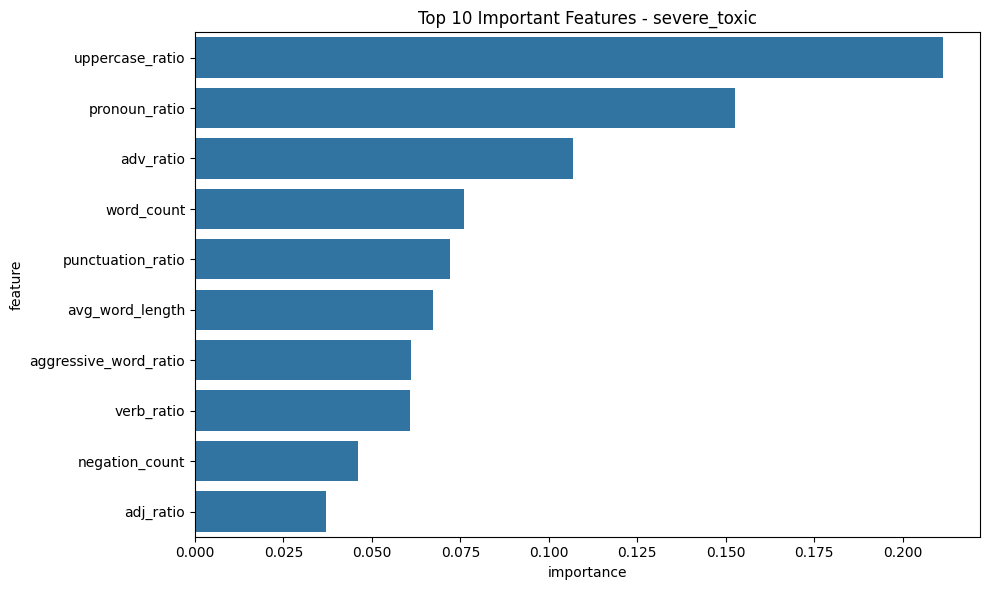


Evaluating obscene classifier...
Class distribution:
obscene
0    0.947249
1    0.052751
Name: proportion, dtype: float64

Results for obscene:
ROC-AUC Score: 0.823

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     30200
           1       0.17      0.67      0.27      1715

    accuracy                           0.81     31915
   macro avg       0.57      0.74      0.58     31915
weighted avg       0.93      0.81      0.85     31915



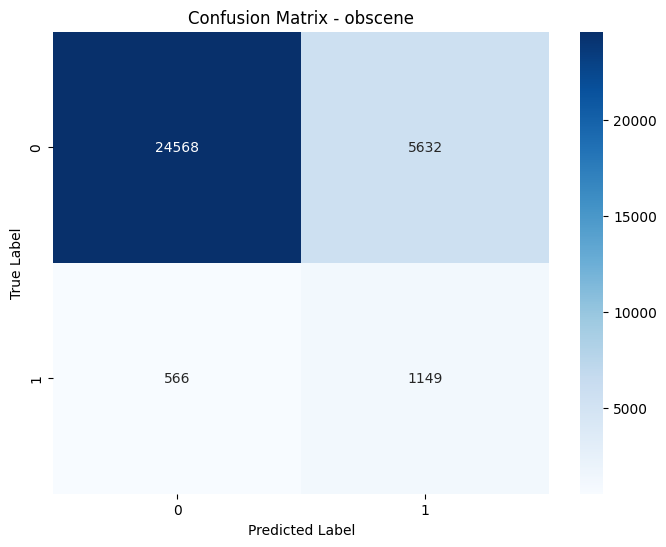

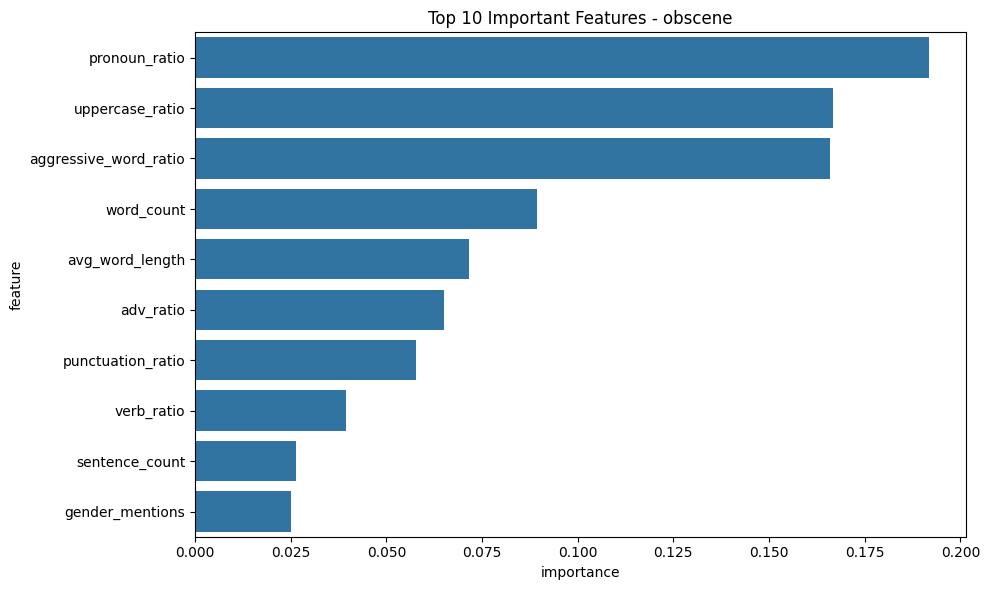


Evaluating threat classifier...
Class distribution:
threat
0    0.996835
1    0.003165
Name: proportion, dtype: float64

Results for threat:
ROC-AUC Score: 0.859

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     31841
           1       0.02      0.32      0.03        74

    accuracy                           0.95     31915
   macro avg       0.51      0.64      0.50     31915
weighted avg       1.00      0.95      0.97     31915



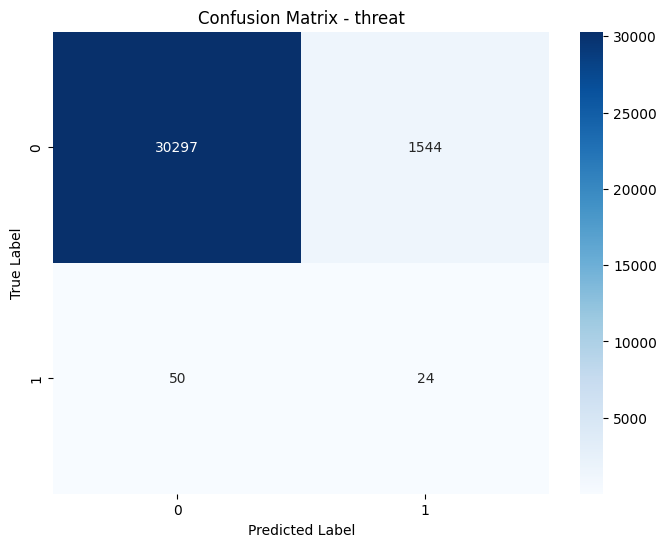

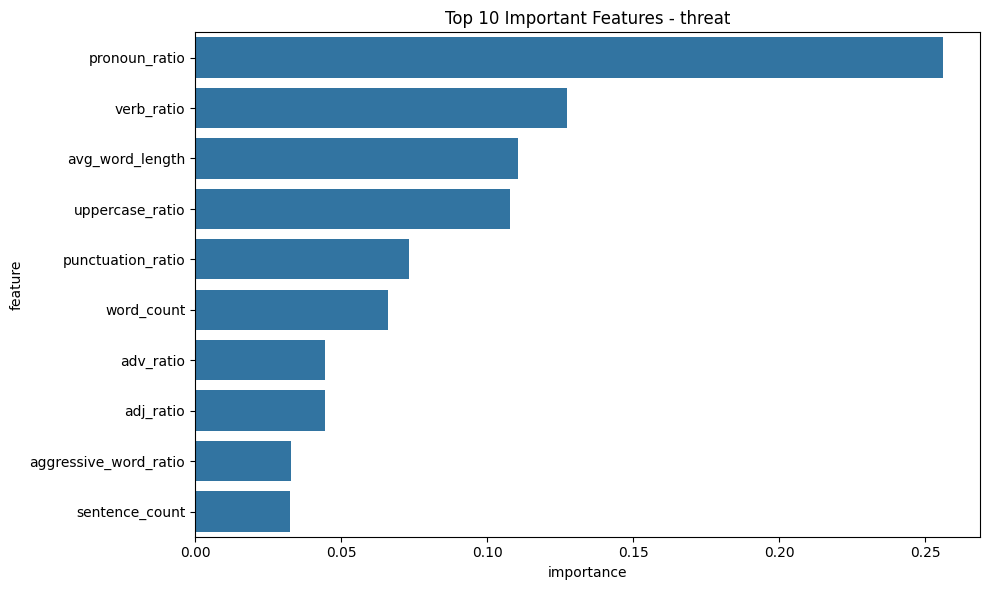


Evaluating insult classifier...
Class distribution:
insult
0    0.950938
1    0.049062
Name: proportion, dtype: float64

Results for insult:
ROC-AUC Score: 0.843

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90     30301
           1       0.18      0.68      0.29      1614

    accuracy                           0.83     31915
   macro avg       0.58      0.76      0.60     31915
weighted avg       0.94      0.83      0.87     31915



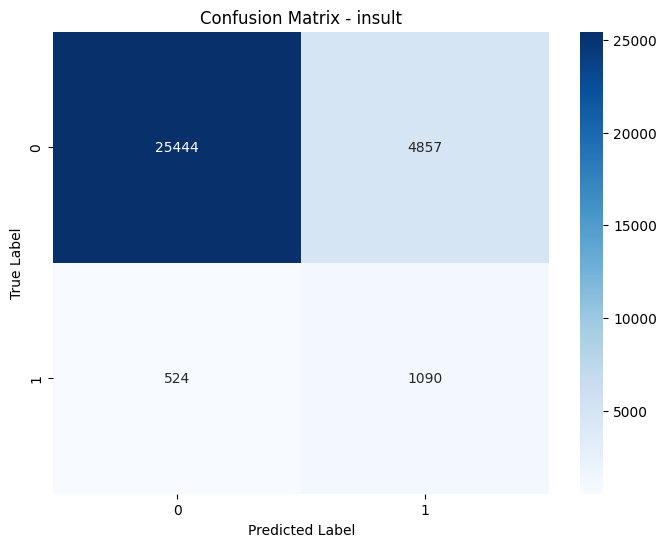

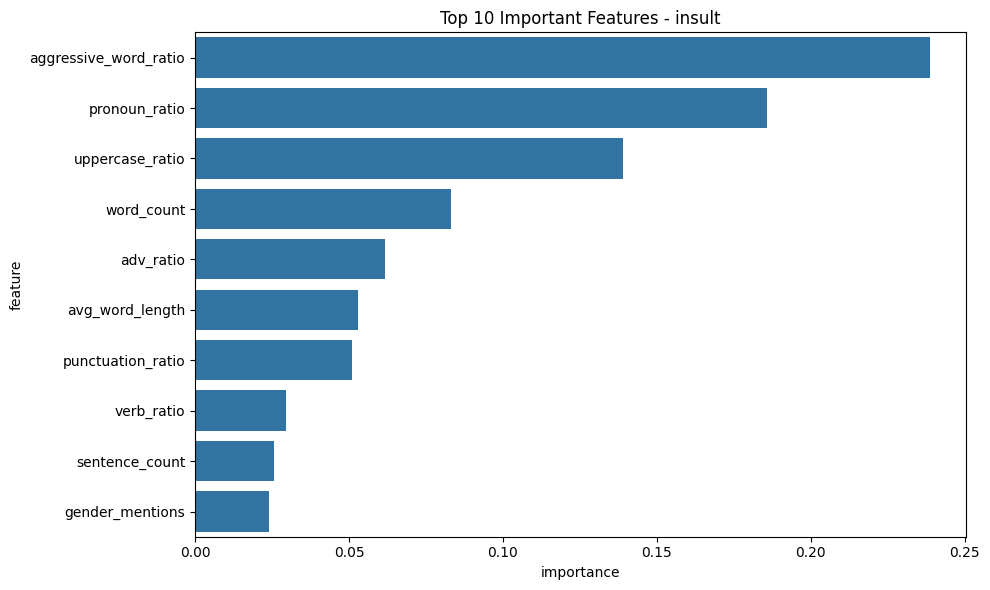


Evaluating identity_hate classifier...
Class distribution:
identity_hate
0    0.991297
1    0.008703
Name: proportion, dtype: float64

Results for identity_hate:
ROC-AUC Score: 0.802

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     31621
           1       0.06      0.45      0.11       294

    accuracy                           0.94     31915
   macro avg       0.53      0.69      0.54     31915
weighted avg       0.99      0.94      0.96     31915



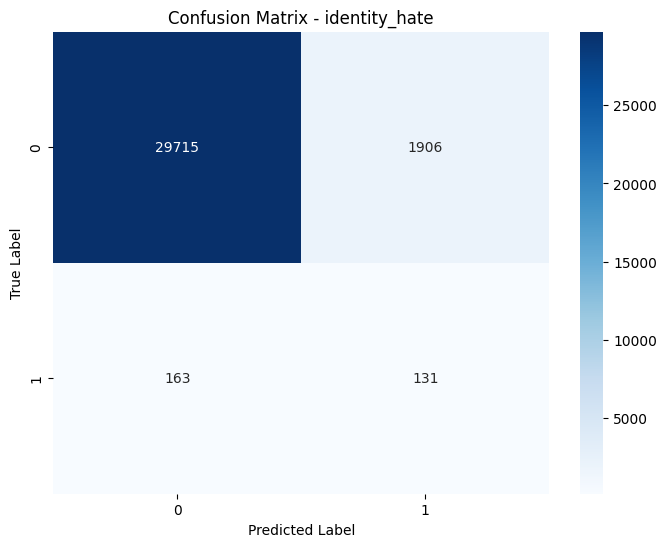

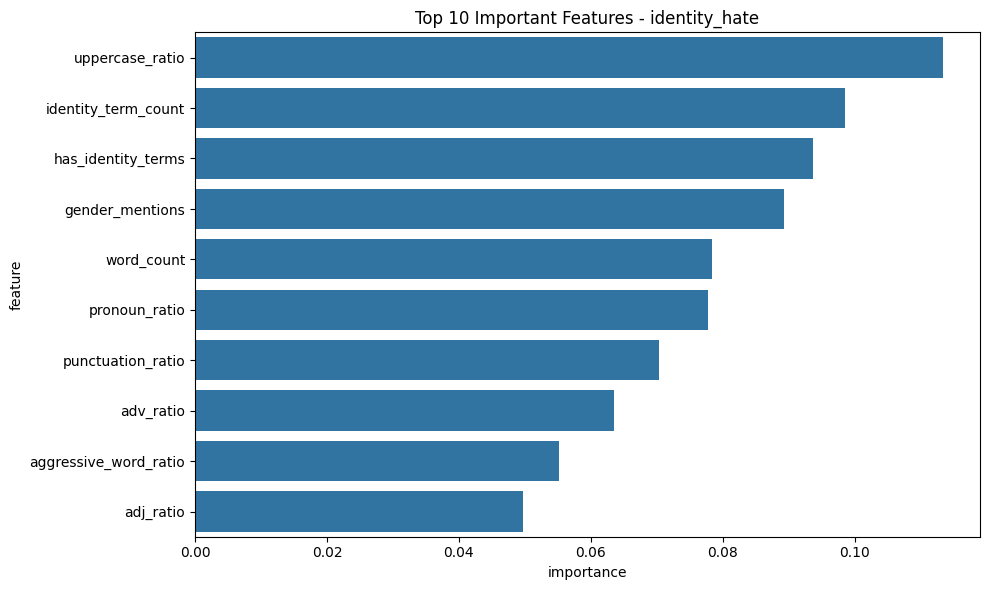


Overall Performance Summary:
     Category  ROC_AUC  Precision   Recall  F1_Score
        toxic 0.817492   0.897959 0.043194  0.082423
 severe_toxic 0.864828   0.062750 0.585670  0.113355
      obscene 0.823477   0.169444 0.669971  0.270480
       threat 0.859171   0.015306 0.324324  0.029233
       insult 0.843407   0.183286 0.675341  0.288322
identity_hate 0.801821   0.064310 0.445578  0.112398

Comparison with BERT embeddings approach:
Manual features advantages:
1. Interpretable features with clear importance rankings
2. Faster training and inference
3. More explainable decisions
4. Lower computational requirements

Manual features limitations:
1. May miss subtle patterns that BERT can capture
2. Requires extensive feature engineering
3. Less flexible for different types of toxic content
4. May need regular updates to patterns and rules


In [20]:
train_features = pd.read_pickle("combined_features.pkl")

feature_columns = [
    # Basic linguistic features
    'word_count', 'avg_word_length', 'sentence_count', 'uppercase_ratio',
    'punctuation_ratio',
    
    # Toxicity features
    'personal_attack_score', 'hate_pattern_count', 'aggressive_word_ratio',
    
    # Bias features
    'stereotype_pattern_count', 'generalization_ratio',
    
    # Syntax features
    'verb_ratio', 'adj_ratio', 'adv_ratio', 'pronoun_ratio', 'imperative_count',
    
    # Emotion features
    'anger_ratio', 'disgust_ratio', 'fear_ratio', 'joy_ratio', 'sadness_ratio',
    
    # Identity features
    'identity_term_count', 'has_identity_terms', 'identity_context_sentiment',
    'gender_mentions', 'race_ethnicity_mentions', 'religion_mentions', 'age_mentions',
    'disability_mentions',
    
    # Polarity features
    'negation_count', 'identity_in_negation', 'identity_positive_context',
    'identity_negative_context'
]

X = train_features[feature_columns]
y = train_features[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features - due to the wide range of feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}

# Train and evaluate for each toxicity category
for category in y.columns:
    print(f"\nEvaluating {category} classifier...")
    
    print("Class distribution:")
    print(y_train[category].value_counts(normalize=True))
    
    # Initialize and train model with class weights
    class_weights = dict(zip(
        y_train[category].unique(),
        len(y_train[category]) / (len(y_train[category].unique()) * y_train[category].value_counts())
    ))
    
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight=class_weights,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_scaled, y_train[category])
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    results[category] = {
        'classification_report': classification_report(y_test[category], y_pred, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test[category], y_pred),
        'roc_auc': roc_auc_score(y_test[category], y_pred_proba),
        'feature_importance': dict(zip(feature_columns, model.feature_importances_))
    }
    
    print(f"\nResults for {category}:")
    print(f"ROC-AUC Score: {results[category]['roc_auc']:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test[category], y_pred))
    
    # Confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(results[category]['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {category}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='importance', y='feature')
    plt.title(f'Top 10 Important Features - {category}')
    plt.tight_layout()
    plt.show()

summary_df = pd.DataFrame({
    'Category': list(results.keys()),
    'ROC_AUC': [results[cat]['roc_auc'] for cat in results],
    'Precision': [results[cat]['classification_report']['1']['precision'] for cat in results],
    'Recall': [results[cat]['classification_report']['1']['recall'] for cat in results],
    'F1_Score': [results[cat]['classification_report']['1']['f1-score'] for cat in results]
})

print("\nOverall Performance Summary:")
print(summary_df.to_string(index=False))


 # Embedding approach

In [21]:
train = pd.read_csv("data/train.csv")

# Split data into toxic and non-toxic
toxic_mask = train["toxic"] == 1
toxic_comments = train[toxic_mask]["comment_text"]
non_toxic_comments = train[~toxic_mask]["comment_text"]

print(f"Toxic comments: {len(toxic_comments)}")
print(f"Non-toxic comments: {len(non_toxic_comments)}")


Toxic comments: 15294
Non-toxic comments: 144277


In [22]:
class EmbeddingProcessor:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        self.max_length = 128

    def get_embeddings(self, df, batch_size=32):
        embeddings = []

        # Process in batches to avoid memory issues
        for i in range(0, len(df), batch_size):
            batch_texts = df["comment_text"][i : i + batch_size].tolist()

            # Tokenize
            inputs = self.tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=self.max_length,
                return_tensors="pt",
            )

            # Get embeddings
            with torch.no_grad():
                outputs = self.model(**inputs)
                # Use [CLS] token embedding as sequence representation
                batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()

            embeddings.append(batch_embeddings)

            if (i + batch_size) % 500 == 0:
                print(f"Processed {i + batch_size}/{len(df)} texts")

        return np.vstack(embeddings)

class EnhancedEmbeddingProcessor(EmbeddingProcessor):
    def get_embeddings(self, df, save_path="embeddings.npy", batch_size=32):
        if os.path.exists(save_path):
            print("Loading pre-computed embeddings...")
            embeddings = np.load(save_path)
            if len(embeddings) == len(df):
                return embeddings
            else:
                print("Saved embeddings don't match current data. Recomputing...")

        print("Computing new embeddings...")
        embeddings = super().get_embeddings(df, batch_size)

        print(f"Saving embeddings to {save_path}")
        np.save(save_path, embeddings)

        return embeddings


def prepare_training_data(df, embeddings, test_size=0.2):
    # Prepare labels (all toxic categories)
    labels = df[
        ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    ].values

    # Create stratified split
    X_train, X_val, y_train, y_val = train_test_split(
        embeddings,
        labels,
        test_size=test_size,
        random_state=42,
        stratify=labels[:, 0],  # Stratify on 'toxic' column
    )

    return X_train, X_val, y_train, y_val

# TODO: Fix the size of the data
processor = EnhancedEmbeddingProcessor()
train_embeddings = processor.get_embeddings(
    train.head(10000), save_path="train_embeddings-10000.npy"
)

X_train, X_val, y_train, y_val = prepare_training_data(
    train.head(10000), train_embeddings
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)


2025-02-07 01:33:21.509427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738884801.586907 1443471 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738884801.608163 1443471 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 01:33:21.786833: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Computing new embeddings...
Processed 4000/10000 texts
Processed 8000/10000 texts
Saving embeddings to train_embeddings-10000.npy
Training set shape: (8000, 768)
Validation set shape: (2000, 768)
Training labels shape: (8000, 6)
Validation labels shape: (2000, 6)


In [27]:
# Analyze embeddings distribution between toxic and non-toxic comments
toxic_mask = train["toxic"].head(10000) == 1
toxic_embeddings = train_embeddings[toxic_mask]
non_toxic_embeddings = train_embeddings[~toxic_mask]

print("Embeddings shape:", train_embeddings.shape)
print("Toxic examples:", len(toxic_embeddings))
print("Non-toxic examples:", len(non_toxic_embeddings))

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(train_embeddings)


Embeddings shape: (10000, 768)
Toxic examples: 971
Non-toxic examples: 9029


 - Each comment is tokenized into words/subwords

 - BERT processes these tokens and produces embeddings for each token

 - The [CLS] token (at position 0) acts as an aggregate representation of the entire comment

 - We get this [CLS] token embedding which is 768-dimensional

     - The number 768 comes from BERT's architecture - specifically, it's the size of BERT-base's hidden layers

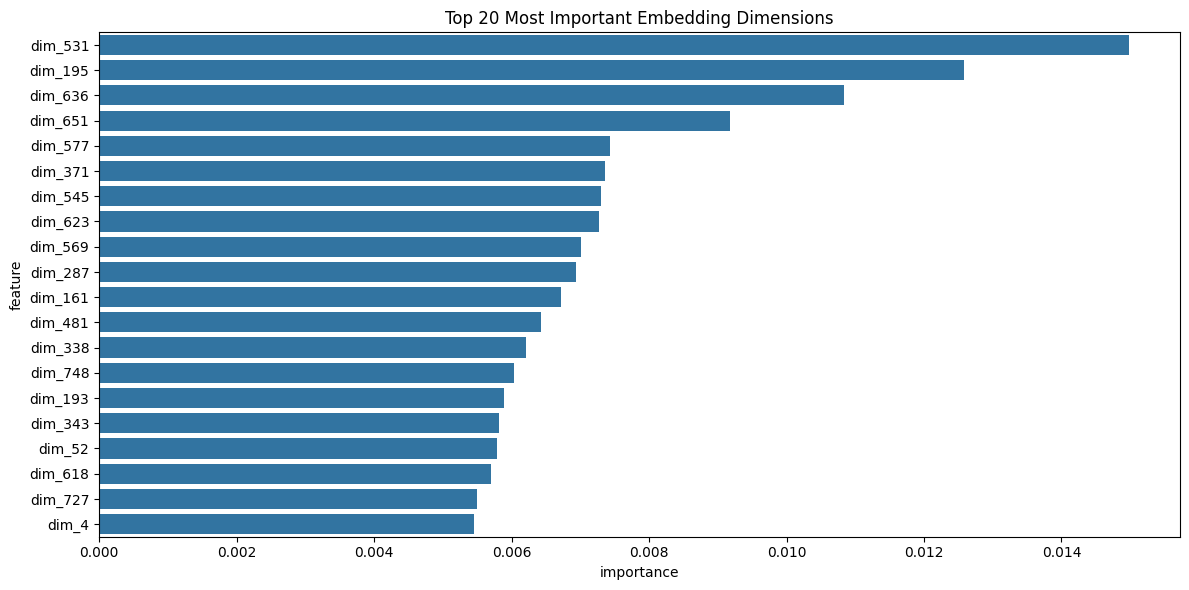

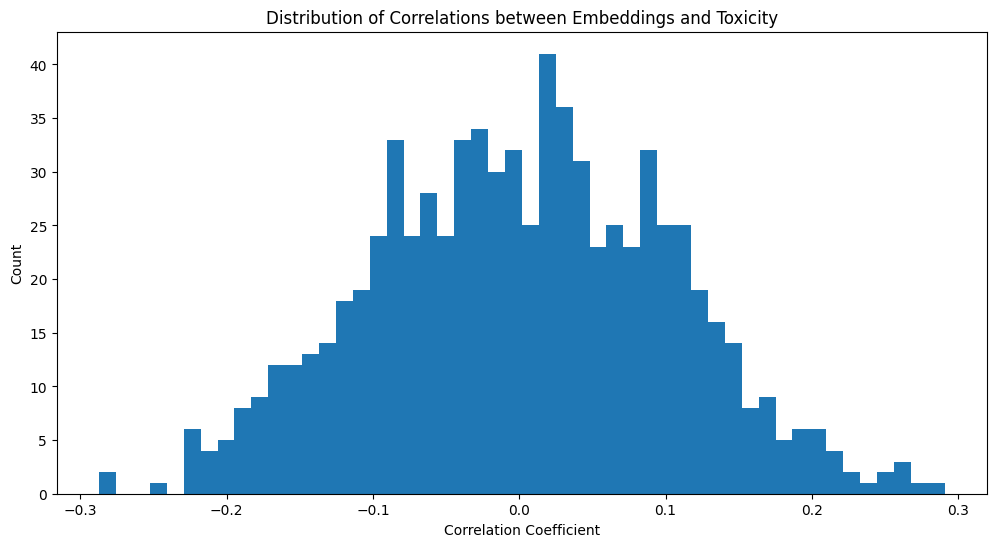


Top dimensions with largest differences between toxic and non-toxic comments:
   dimension  difference
0        667    0.231628
1        273    0.233947
2        308    0.234826
3        748    0.236984
4        371    0.238168
5        623    0.240040
6        338    0.245483
7        109    0.251819
8        636    0.255115
9        752    0.356585


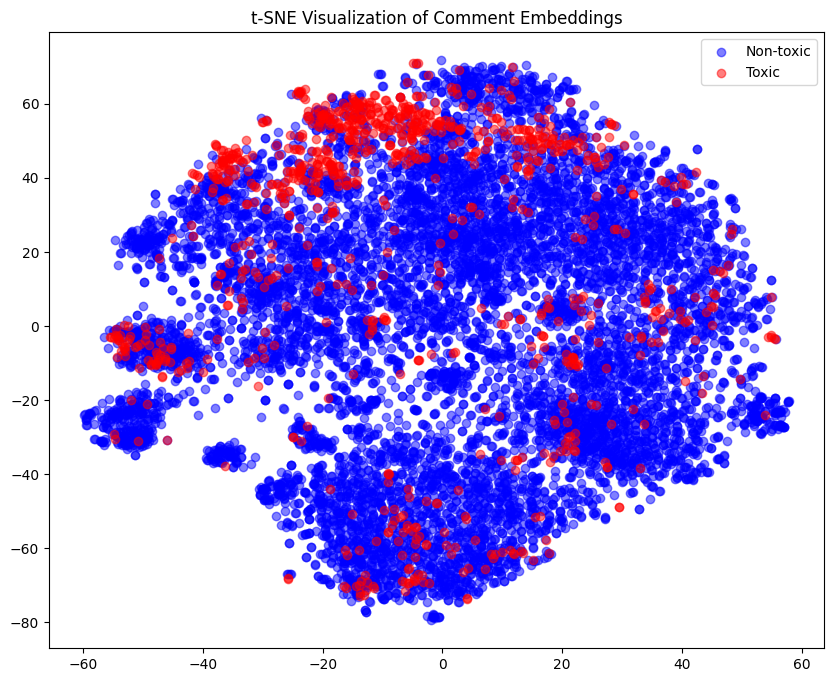

In [31]:
# Random Forest to get feature importance
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_embeddings, train["toxic"].head(10000))

importances = rf_classifier.feature_importances_
feature_importance = pd.DataFrame(
    {
        "feature": [f"dim_{i}" for i in range(len(importances))],
        "importance": importances,
    }
)

# top 20 important features
plt.figure(figsize=(12, 6))
top_features = feature_importance.nlargest(20, "importance")
sns.barplot(data=top_features, x="importance", y="feature")
plt.title("Top 20 Most Important Embedding Dimensions")
plt.tight_layout()
plt.show()

# correlation between embeddings and toxicity
correlations = []
toxic_labels = train["toxic"].head(10000).values

for i in range(train_embeddings.shape[1]):
    correlation = np.corrcoef(train_embeddings[:, i], toxic_labels)[0, 1]
    correlations.append(correlation)

plt.figure(figsize=(12, 6))
plt.hist(correlations, bins=50)
plt.title("Distribution of Correlations between Embeddings and Toxicity")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Count")
plt.show()


# toxic vs non-toxic comments
def analyze_embedding_differences():
    toxic_mean = np.mean(toxic_embeddings, axis=0)
    non_toxic_mean = np.mean(non_toxic_embeddings, axis=0)

    differences = np.abs(toxic_mean - non_toxic_mean)

    top_dims = np.argsort(differences)[-10:]

    return pd.DataFrame({"dimension": top_dims, "difference": differences[top_dims]})


diff_df = analyze_embedding_differences()
print("\nTop dimensions with largest differences between toxic and non-toxic comments:")
print(diff_df)

# Visualize separation - toxic vs non-toxic comments
# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(train_embeddings)

# Create visualization
plt.figure(figsize=(10, 8))
plt.scatter(
    embeddings_2d[~toxic_mask, 0],
    embeddings_2d[~toxic_mask, 1],
    alpha=0.5,
    label="Non-toxic",
    c="blue",
)
plt.scatter(
    embeddings_2d[toxic_mask, 0],
    embeddings_2d[toxic_mask, 1],
    alpha=0.5,
    label="Toxic",
    c="red",
)
plt.title("t-SNE Visualization of Comment Embeddings")
plt.legend()
plt.show()



In [33]:
def analyze_patterns():
    # Get most toxic and least toxic comments based on embeddings
    toxic_scores = rf_classifier.predict_proba(train_embeddings)[
        :, 1
    ]  

    analysis_df = pd.DataFrame(
        {
            "text": train["comment_text"].head(10000),
            "toxic_score": toxic_scores,
            "is_toxic": train["toxic"].head(10000),
        }
    )

    print("\nHighest confidence toxic predictions:")
    print(
        analysis_df[analysis_df["is_toxic"] == 1].nlargest(5, "toxic_score")[
            ["text", "toxic_score"]
        ]
    )

    print("\nHighest confidence non-toxic predictions:")
    print(
        analysis_df[analysis_df["is_toxic"] == 0].nsmallest(5, "toxic_score")[
            ["text", "toxic_score"]
        ]
    )

    return analysis_df


analysis_results = analyze_patterns()


Highest confidence toxic predictions:
                                                                                                     text  \
8380                                           FUCK YOU, GO SUCK SOME DOG COCK! YOU FUCKING DICK LICKERS!   
2791  You can't fucking block me for 3 months for fucking personal attacks or harassment! You fucking ...   
2945                              Hey I'm just tellin' like it is you ugly as fuck butt fugly muthafucka!   
43                                                               FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!   
806                                                                      I shit on your face \n\nfuck you   

      toxic_score  
8380         0.99  
2791         0.98  
2945         0.98  
43           0.97  
806          0.97  

Highest confidence non-toxic predictions:
                                                                                                   text  \
1   D'aww! He matches this backgroun

 ## Feature interpreration

In [34]:
def interpret_important_features(text_examples):
    if isinstance(text_examples, pd.Series):
        text_examples = text_examples.tolist()

    inputs = processor.tokenizer(
        text_examples, return_tensors="pt", padding=True, truncation=True
    )

    with torch.no_grad():
        outputs = processor.model(**inputs, output_attentions=True)
        attentions = outputs.attentions

    # words the model pays attention to
    for idx, text in enumerate(text_examples):
        tokens = processor.tokenizer.tokenize(text)
        attention_weights = attentions[-1][idx].mean(dim=0).mean(dim=0)

        # word importance pairs
        word_importance = list(zip(tokens, attention_weights.numpy()))
        word_importance.sort(key=lambda x: x[1], reverse=True)

        print(f"\nText: {text}")
        print("Most important words by attention weight:")
        for word, weight in word_importance[:5]:
            print(f"  {word}: {weight:.4f}")


# Get some example texts that were correctly classified
correct_toxics = analysis_results[
    (analysis_results["is_toxic"] == 1) & (analysis_results["toxic_score"] > 0.9)
]["text"].tolist()  # Convert to list here

interpret_important_features(correct_toxics[:3])  # Take first 3 examples


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



Text: FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
Most important words by attention weight:
  !: 0.0638
  fuck: 0.0556
  your: 0.0499
  filthy: 0.0353
  in: 0.0315

Text: you are a stupid fuck 

and your mother's cunt stinks
Most important words by attention weight:
  you: 0.0406
  stink: 0.0364
  your: 0.0336
  and: 0.0296
  ##nt: 0.0274

Text: Fuck you, block me, you faggot pussy!
Most important words by attention weight:
  you: 0.2851
  fuck: 0.0429
  me: 0.0417
  fa: 0.0374
  !: 0.0329


 ### Misclassified

In [ ]:
def analyze_errors():
    predictions = rf_classifier.predict(train_embeddings)
    # TODO:FIX SIZE
    actual = train["toxic"].head(10000).values

    error_analysis_df = pd.DataFrame(
        {"text": train["comment_text"], "predicted": predictions, "actual": actual}
    )

    false_positives = error_analysis_df[
        (error_analysis_df["predicted"] == 1) & (error_analysis_df["actual"] == 0)
    ]

    false_negatives = error_analysis_df[
        (error_analysis_df["predicted"] == 0) & (error_analysis_df["actual"] == 1)
    ]

    print(f"\nFound {len(false_positives)} false positives")
    print(f"Found {len(false_negatives)} false negatives")

    if len(false_positives) > 0:
        print("\nFalse Positive Examples (Non-toxic classified as toxic):")
        for text in false_positives["text"].head(3):
            print(f"\n- {text}")

        if len(false_positives) >= 3:
            print("\nAnalyzing false positive patterns:")
            interpret_important_features(false_positives["text"].head(3).tolist())
    else:
        print("\nNo false positives found.")

    if len(false_negatives) > 0:
        print("\nFalse Negative Examples (Toxic classified as non-toxic):")
        for text in false_negatives["text"].head(3):
            print(f"\n- {text}")

        if len(false_negatives) >= 3:
            print("\nAnalyzing false negative patterns:")
            interpret_important_features(false_negatives["text"].head(3).tolist())
    else:
        print("\nNo false negatives found.")

    return false_positives, false_negatives


fp_df, fn_df = analyze_errors()

In [37]:
def analyze_prediction_confidence():
    # Get prediction probabilities
    probabilities = rf_classifier.predict_proba(train_embeddings)

    # Create DataFrame with predictions and actual values
    confidence_df = pd.DataFrame(
        {
            "text": train["comment_text"].head(10000),
            "toxic_probability": probabilities[:, 1],  # Probability of being toxic
            "actual": train["toxic"].head(10000),
        }
    )

    # Add confidence level categories
    confidence_df["confidence_level"] = pd.cut(
        confidence_df["toxic_probability"],
        bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=["Very Low", "Low", "Moderate", "High", "Very High"],
    )

    # Analyze borderline cases (predictions close to 0.5)
    borderline = confidence_df[
        (confidence_df["toxic_probability"] > 0.4)
        & (confidence_df["toxic_probability"] < 0.6)
    ]

    print("\nConfidence Level Distribution:")
    print(confidence_df["confidence_level"].value_counts())

    print("\nBorderline Cases (predictions near 0.5):")
    for _, row in borderline.head(3).iterrows():
        print(f"\nText: {row['text']}")
        print(f"Predicted Probability: {row['toxic_probability']:.3f}")
        print(f"Actual Label: {'Toxic' if row['actual'] == 1 else 'Non-toxic'}")

    return confidence_df, borderline


confidence_df, borderline_cases = analyze_prediction_confidence()


# very high confidence correct predictions
def analyze_high_confidence_cases():
    high_conf_correct = confidence_df[
        ((confidence_df["toxic_probability"] > 0.9) & (confidence_df["actual"] == 1))
        | ((confidence_df["toxic_probability"] < 0.1) & (confidence_df["actual"] == 0))
    ]

    print("\nHigh Confidence Correct Predictions:")
    for _, row in high_conf_correct.head(3).iterrows():
        print(f"\nText: {row['text']}")
        print(f"Predicted Probability: {row['toxic_probability']:.3f}")
        print(f"Actual: {'Toxic' if row['actual'] == 1 else 'Non-toxic'}")

analyze_high_confidence_cases()



Confidence Level Distribution:
confidence_level
Very Low     6836
High          663
Very High     288
Low            21
Moderate       20
Name: count, dtype: int64

Borderline Cases (predictions near 0.5):

Text: God is dead
I don't mean to startle anyone but God is dead. We should not worry about him anymore. Just thought I would let everyone know. Well, goodbye and good luck with your newfound crisis of faith! 24.77.205.229
Predicted Probability: 0.590
Actual Label: Toxic

Text: "
That was a nice message on my talk page. I enjoyed it. I mean, you still suck, but yeah, I had fun.  talk "
Predicted Probability: 0.580
Actual Label: Toxic

Text: "

Here's ONE example of McNeight-speak

Your post to Wikipedia talk:Requests for comment does not provide enough information so that anyone can review the threats and personal attacks that you claim were made by  

http://en.wikipedia.org/wiki/Wikipedia_talk:Requests_for_comment/Braaad

QUOTE from McNeight:
Wikipedia is a community. The focus i


Evaluating toxic classifier...

Results for toxic:
ROC-AUC Score: 0.930

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1806
           1       0.91      0.26      0.40       194

    accuracy                           0.93      2000
   macro avg       0.92      0.63      0.68      2000
weighted avg       0.92      0.93      0.91      2000


Class distribution in validation set:
{np.int64(0): np.int64(1806), np.int64(1): np.int64(194)}
Positive class ratio: 9.700%

Evaluating severe_toxic classifier...

Results for severe_toxic:
ROC-AUC Score: 0.947

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1975
           1       0.00      0.00      0.00        25

    accuracy                           0.99      2000
   macro avg       0.49      0.50      0.50      2000
weighted avg       0.98      0.99      0.98      2000


Class distr

/home/stv4sf/Documents/Other/toxic-comments-classification/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stv4sf/Documents/Other/toxic-comments-classification/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stv4sf/Documents/Other/toxic-comments-classification/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi


Results for threat:
ROC-AUC Score: 0.853

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1991
           1       0.00      0.00      0.00         9

    accuracy                           1.00      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.99      1.00      0.99      2000


Class distribution in validation set:
{np.int64(0): np.int64(1991), np.int64(1): np.int64(9)}
Positive class ratio: 0.450%

Evaluating insult classifier...

Results for insult:
ROC-AUC Score: 0.907

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1908
           1       0.75      0.20      0.31        92

    accuracy                           0.96      2000
   macro avg       0.86      0.60      0.64      2000
weighted avg       0.95      0.96      0.95      2000


Class distribution in validation set:
{np.int64(0): np.i

/home/stv4sf/Documents/Other/toxic-comments-classification/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stv4sf/Documents/Other/toxic-comments-classification/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stv4sf/Documents/Other/toxic-comments-classification/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi


Results for identity_hate:
ROC-AUC Score: 0.916

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1985
           1       0.00      0.00      0.00        15

    accuracy                           0.99      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.99      0.99      0.99      2000


Class distribution in validation set:
{np.int64(0): np.int64(1985), np.int64(1): np.int64(15)}
Positive class ratio: 0.750%


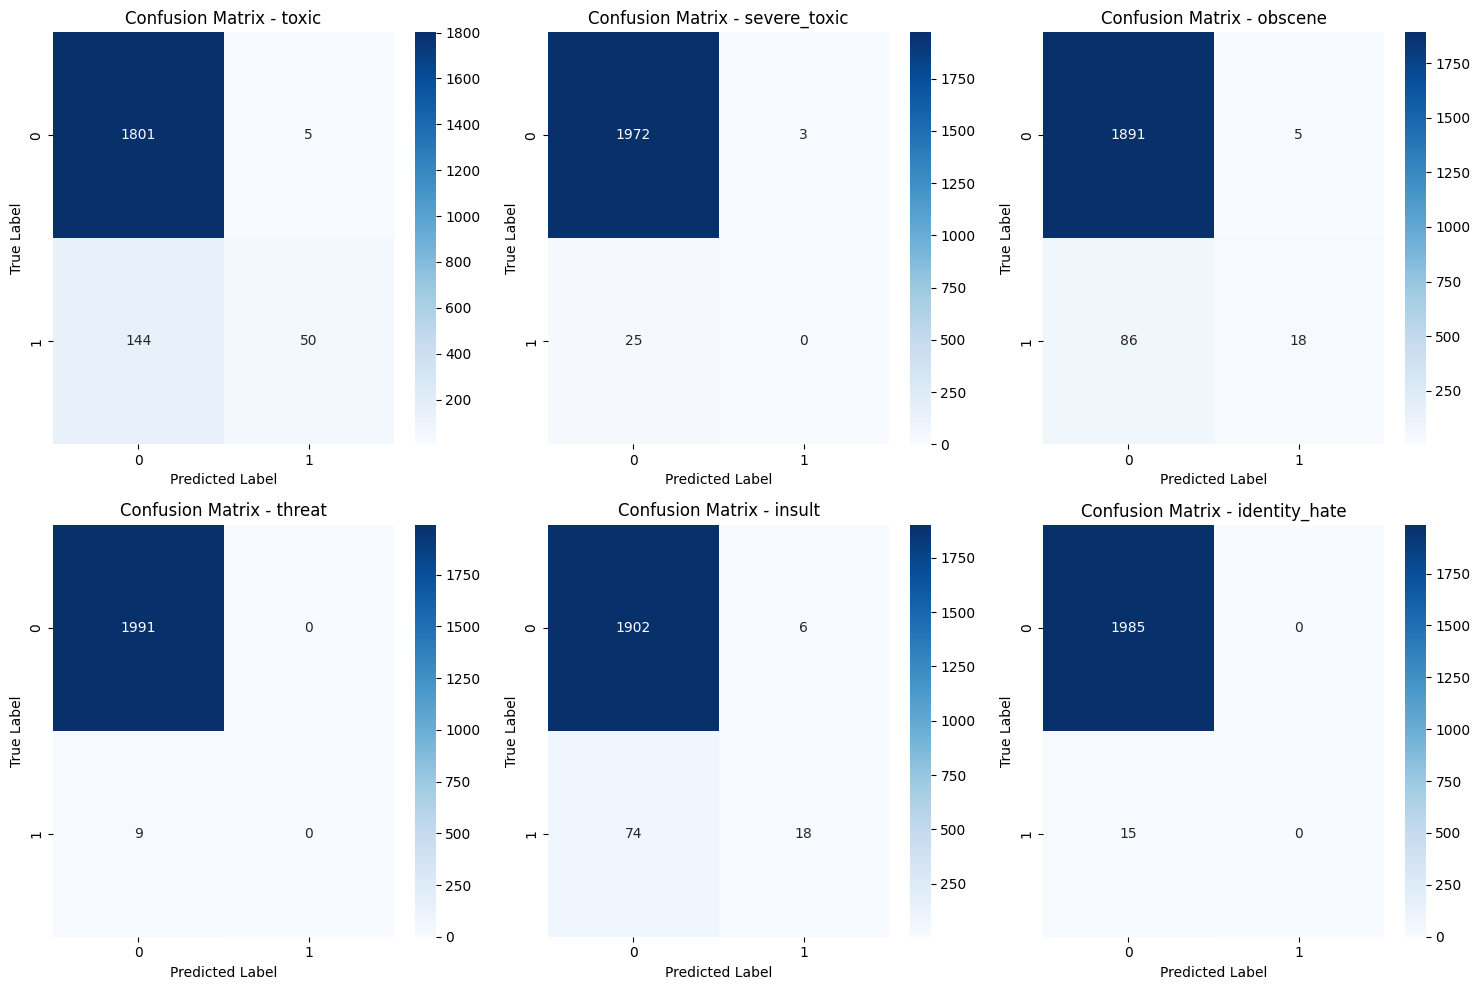

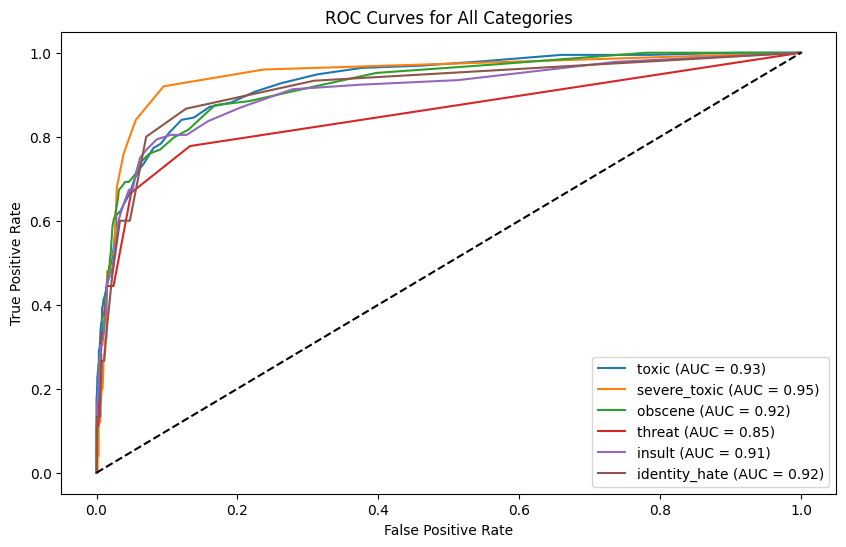

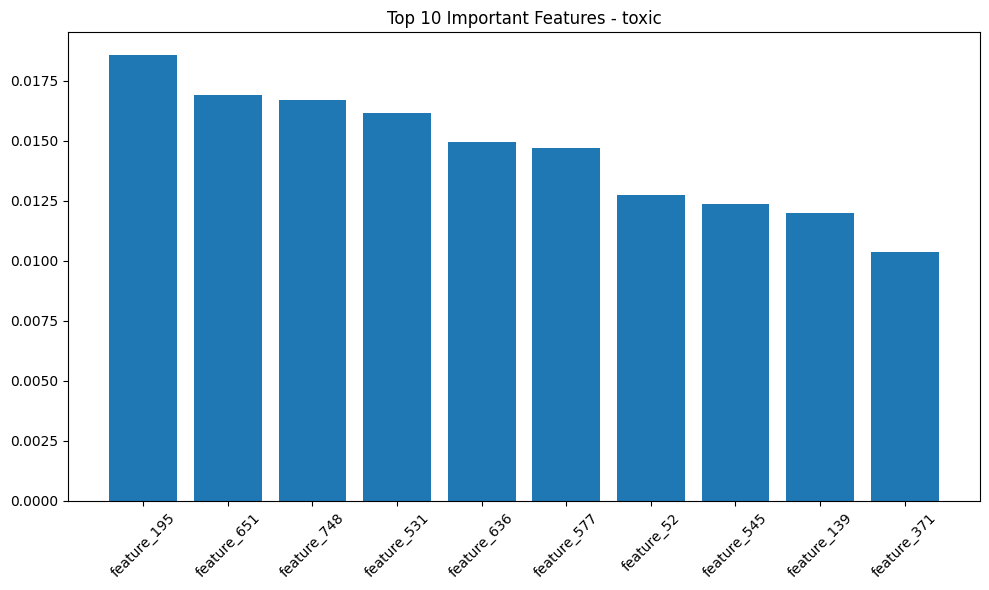

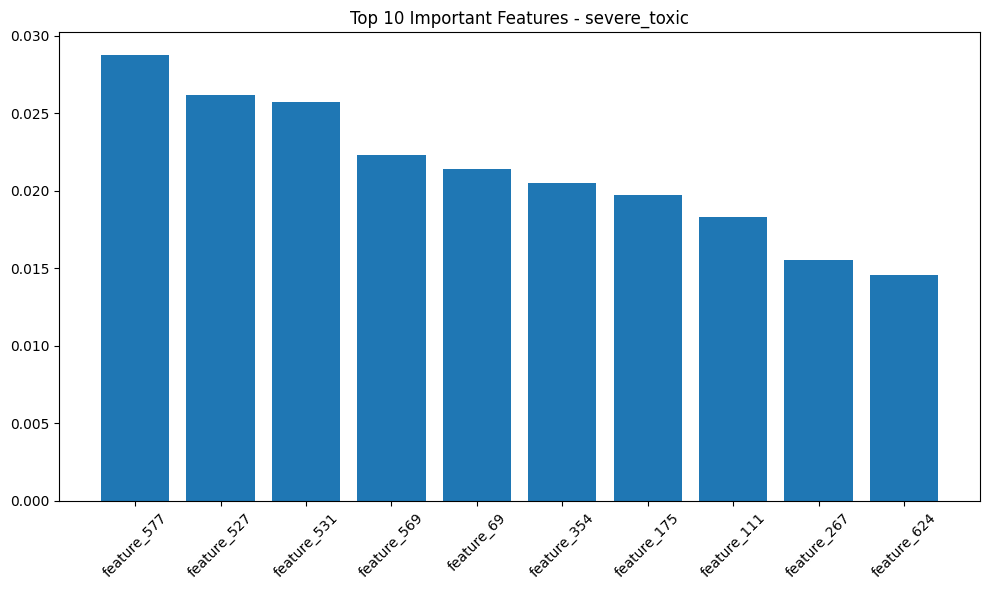

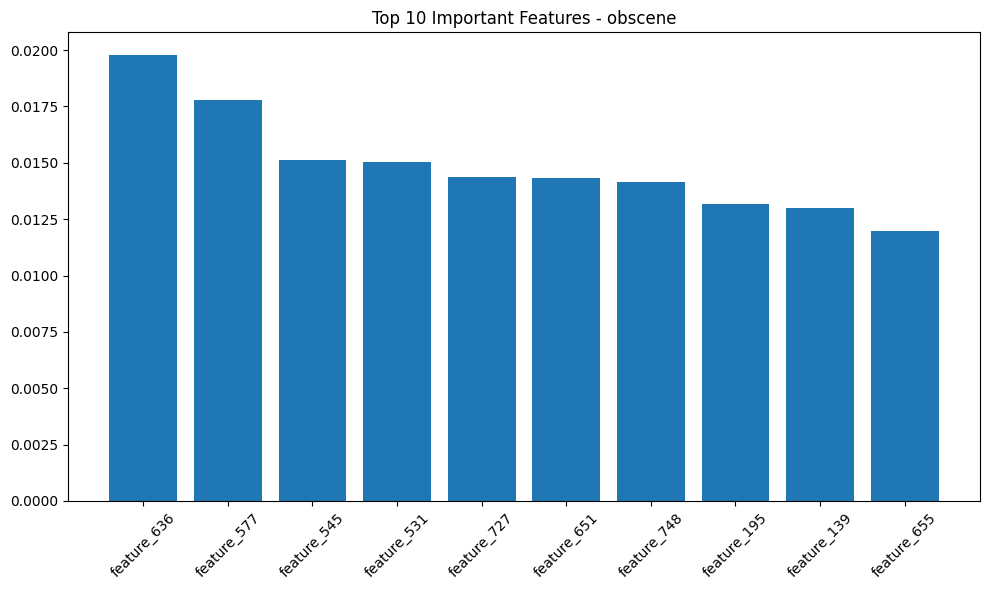

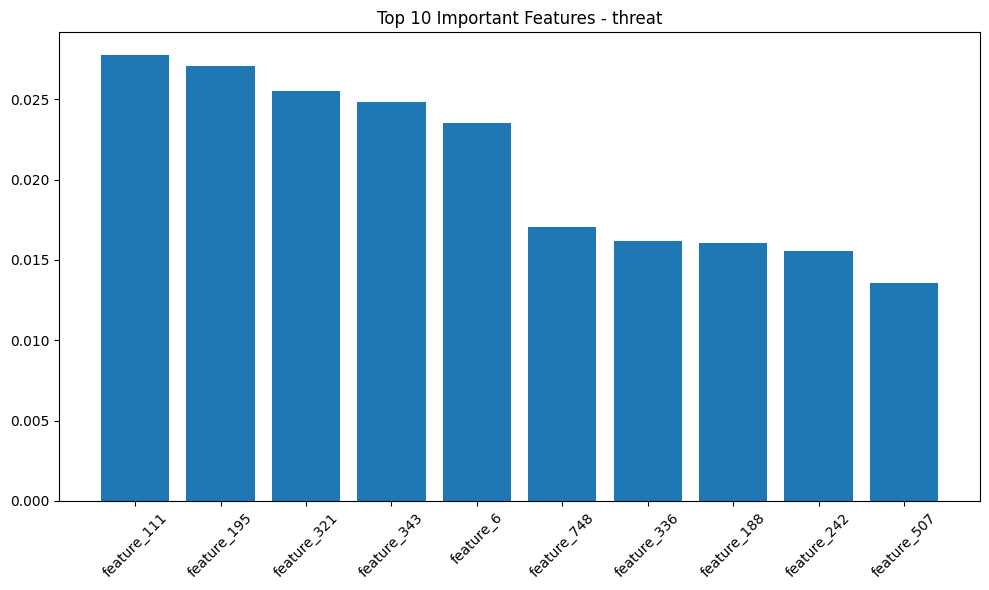

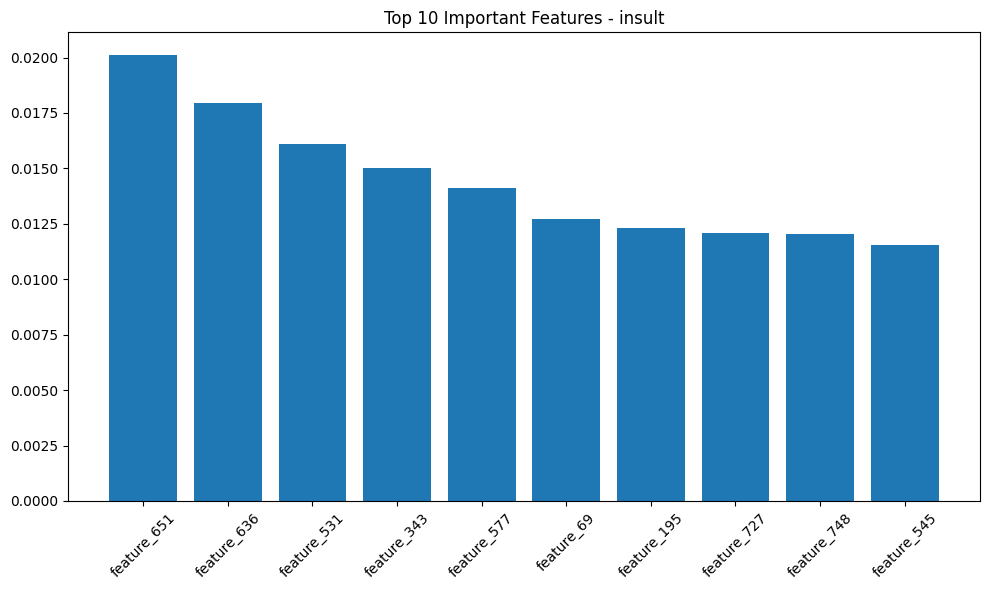

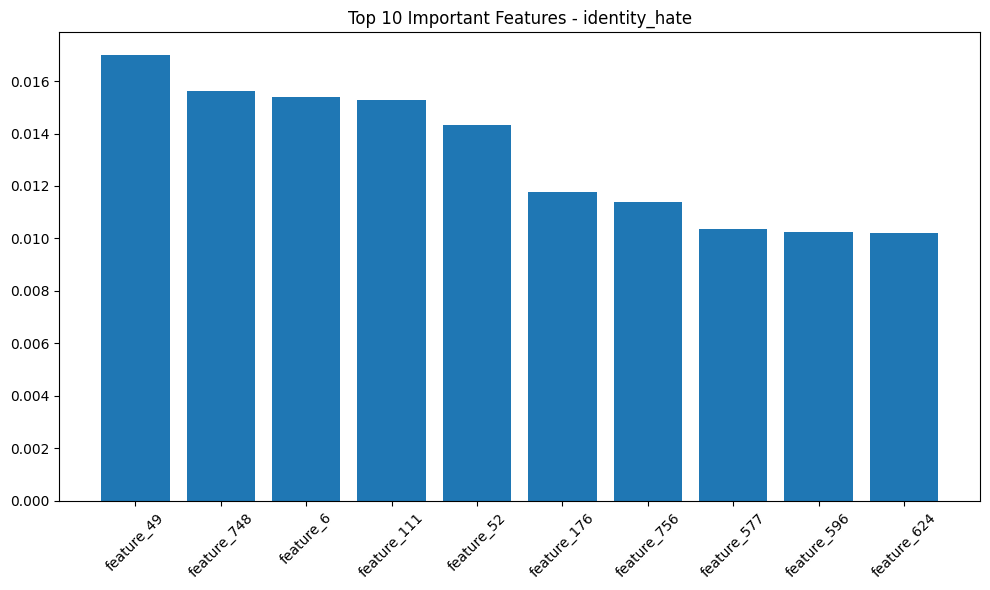


Misclassification Analysis for toxic:

False Positives (Non-toxic classified as toxic):
Text: Thank you - I'm glad I could help you. As always, let me know if you need anything else.  (talk • contributions)
Confidence: 0.510

Text: "
That'd be alright, but as I'm not a bureaucrat, you'd have to ask at your request for one to see it. Thanks,  [Talk] "
Confidence: 0.630

Text: I assume this is in Washington in USA, even though the article does not say where it is.
Confidence: 0.590


False Negatives (Toxic classified as non-toxic):
Text: "::Root's screenshot is exactly how it looks for me (monobook  and latest Google Chrome).  | Penny for your thoughts?   

"
Confidence: 0.100

Text: "

 National Archives ExtravaSCANza 
You are invited to the National Archives ExtravaSCANza, taking place every day next week from January 4–7, Wednesday to Saturday, in College Park, Maryland (Washington, DC metro area). Come help me cap off my stint as Wikipedian in Residence at the National Archives with

In [38]:
class ToxicityModelEvaluator:
    def __init__(
        self,
        category_names=[
            "toxic",
            "severe_toxic",
            "obscene",
            "threat",
            "insult",
            "identity_hate",
        ],
    ):
        self.category_names = category_names

    def train_and_evaluate(self, X_train, X_val, y_train, y_val):
        """Train models for each category and evaluate them"""
        self.models = {}
        self.results = {}

        for i, category in enumerate(self.category_names):
            print(f"\nEvaluating {category} classifier...")

            unique, counts = np.unique(y_train[:, i], return_counts=True)
            class_weight = dict(zip(unique, len(y_train) / (len(unique) * counts)))

            model = RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                class_weight=class_weight,
                n_jobs=-1,  # Use all available cores
            )
            model.fit(X_train, y_train[:, i])
            self.models[category] = model

            y_pred = model.predict(X_val)
            y_pred_proba = model.predict_proba(X_val)[:, 1]

            self.results[category] = {
                "classification_report": classification_report(
                    y_val[:, i], y_pred, output_dict=True
                ),
                "roc_auc": roc_auc_score(y_val[:, i], y_pred_proba),
                "confusion_matrix": confusion_matrix(y_val[:, i], y_pred),
                "predictions": y_pred,
                "probabilities": y_pred_proba,
            }

            print(f"\nResults for {category}:")
            print(f"ROC-AUC Score: {self.results[category]['roc_auc']:.3f}")
            print("\nClassification Report:")
            print(classification_report(y_val[:, i], y_pred, zero_division=0))

            unique, counts = np.unique(y_val[:, i], return_counts=True)
            print(f"\nClass distribution in validation set:")
            print(dict(zip(unique, counts)))
            print(
                f"Positive class ratio: {counts[1] / len(y_val) if 1 in unique else 0:.3%}"
            )

    def plot_confusion_matrices(self):
        """Plot confusion matrices for all categories"""
        n_cats = len(self.category_names)
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for i, category in enumerate(self.category_names):
            cm = self.results[category]["confusion_matrix"]
            sns.heatmap(cm, annot=True, fmt="d", ax=axes[i], cmap="Blues")
            axes[i].set_title(f"Confusion Matrix - {category}")
            axes[i].set_ylabel("True Label")
            axes[i].set_xlabel("Predicted Label")

        plt.tight_layout()
        plt.show()

    def plot_roc_curves(self, X_val, y_val):
        """Plot ROC curves for all categories"""
        plt.figure(figsize=(10, 6))

        for i, category in enumerate(self.category_names):
            model = self.models[category]
            y_pred_proba = model.predict_proba(X_val)[:, 1]

            fpr, tpr, _ = roc_curve(y_val[:, i], y_pred_proba)
            plt.plot(
                fpr,
                tpr,
                label=f"{category} (AUC = {self.results[category]['roc_auc']:.2f})",
            )

        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves for All Categories")
        plt.legend()
        plt.show()

    def analyze_feature_importance(self, feature_names=None):
        """Analyze feature importance for each category"""
        if feature_names is None:
            feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

        # TODO: Rethink significance of these plots
        for category in self.category_names:
            model = self.models[category]
            importance = model.feature_importances_

            # Get top 10 features
            top_indices = importance.argsort()[-10:][::-1]

            plt.figure(figsize=(10, 6))
            plt.bar(range(10), importance[top_indices])
            plt.xticks(range(10), [feature_names[i] for i in top_indices], rotation=45)
            plt.title(f"Top 10 Important Features - {category}")
            plt.tight_layout()
            plt.show()

    def analyze_misclassifications(self, X_val, y_val, texts):
        """Analyze misclassified examples for each category"""
        for i, category in enumerate(self.category_names):
            predictions = self.results[category]["predictions"]
            probabilities = self.results[category]["probabilities"]

            misclassified = predictions != y_val[:, i]

            misclassified_df = pd.DataFrame(
                {
                    "text": texts[misclassified],
                    "true_label": y_val[misclassified, i],
                    "predicted_proba": probabilities[misclassified],
                }
            )

            print(f"\nMisclassification Analysis for {category}:")

            false_positives = misclassified_df[misclassified_df["true_label"] == 0]
            false_negatives = misclassified_df[misclassified_df["true_label"] == 1]

            print("\nFalse Positives (Non-toxic classified as toxic):")
            for _, row in false_positives.head(3).iterrows():
                print(f"Text: {row['text']}")
                print(f"Confidence: {row['predicted_proba']:.3f}\n")

            print("\nFalse Negatives (Toxic classified as non-toxic):")
            for _, row in false_negatives.head(3).iterrows():
                print(f"Text: {row['text']}")
                print(f"Confidence: {row['predicted_proba']:.3f}\n")


evaluator = ToxicityModelEvaluator()
evaluator.train_and_evaluate(X_train, X_val, y_train, y_val)
evaluator.plot_confusion_matrices()
evaluator.plot_roc_curves(X_val, y_val)
evaluator.analyze_feature_importance()

# TODO: Size
evaluator.analyze_misclassifications(
    X_val, y_val, train.head(10000)["comment_text"].values[len(X_train) :]
)

performance_summary = pd.DataFrame(
    {
        "Category": evaluator.category_names,
        "ROC_AUC": [
            evaluator.results[cat]["roc_auc"] for cat in evaluator.category_names
        ],
        "Precision": [
            evaluator.results[cat]["classification_report"]["1"]["precision"]
            for cat in evaluator.category_names
        ],
        "Recall": [
            evaluator.results[cat]["classification_report"]["1"]["recall"]
            for cat in evaluator.category_names
        ],
        "F1_Score": [
            evaluator.results[cat]["classification_report"]["1"]["f1-score"]
            for cat in evaluator.category_names
        ],
    }
)

print("\nOverall Performance Summary:")
print(performance_summary.to_string(index=False))


# Compare BERT vs Random Forest with manual embeddings results

## Manual features advantages:
1. Interpretable features with clear importance rankings  
2. Faster training and inference  
3. More explainable decisions  
4. Lower computational requirements  

## Manual features limitations:
1. May miss subtle patterns that BERT can capture  
2. Requires extensive feature engineering  
3. Less flexible for different types of toxic content  
4. May need regular updates to patterns and rules  


# LSTM

In [1]:
# Disable GPU and suppress TensorFlow warnings for stability
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    Embedding,
    Dropout,
    Bidirectional,
    SpatialDropout1D,
    BatchNormalization,
    Activation,
    Lambda,
    RepeatVector,
    Permute,
    Flatten,
    multiply,
    GlobalAveragePooling1D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
import tensorflow.keras.backend as K

class DataAnalyzer:
    """
    Analyzes text data to determine optimal model parameters and class distributions.
    """
    @staticmethod
    def analyze_vocabulary_size(texts):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(texts)

        # Analyze word frequencies
        word_counts = pd.Series(tokenizer.word_counts)
        total_words = len(word_counts)
        # Find number of words needed for 90% coverage
        coverage_90 = word_counts.sort_values(ascending=False).cumsum()
        coverage_90 = coverage_90[coverage_90 <= 0.9 * coverage_90.sum()].count()

        print(f"Total unique words: {total_words}")
        print(f"Words needed for 90% coverage: {coverage_90}")
        return coverage_90

    @staticmethod
    def analyze_sequence_length(texts):
        # Calculate length of each text
        lengths = texts.str.split().str.len()

        print("Text length statistics:")
        print(f"Mean length: {lengths.mean():.1f} words")
        print(f"Median length: {lengths.median():.1f} words")
        print(f"95th percentile: {lengths.quantile(0.95):.1f} words")

        return lengths.quantile(0.95).astype(int)

    @staticmethod
    def analyze_class_distribution(y):
        """Analyzes class distribution and prints statistics."""
        class_names = [
            "toxic",
            "severe_toxic",
            "obscene",
            "threat",
            "insult",
            "identity_hate",
        ]
        print("\nClass Distribution Analysis:")
        for i, name in enumerate(class_names):
            pos_count = np.sum(y[:, i])
            total = len(y)
            print(
                f"{name}: {pos_count} positive samples ({pos_count / total * 100:.2f}%)"
            )

    @staticmethod
    def get_optimal_parameters(texts):
        """Determines optimal model parameters based on data characteristics."""
        # Analyze vocabulary
        vocab_size = DataAnalyzer.analyze_vocabulary_size(texts)
        max_features = min(int(vocab_size * 1.2), 200000)  # Add 20% buffer

        # Analyze sequence length
        maxlen = DataAnalyzer.analyze_sequence_length(texts)

        # Choose embedding size based on vocabulary size
        if max_features < 50000:
            embed_size = 100
        elif max_features < 100000:
            embed_size = 200
        else:
            embed_size = 300

        return max_features, maxlen, embed_size


class TextPreprocessor:
    """Handles text preprocessing with safeguards against data leakage."""

    def __init__(self, max_features):
        self.tokenizer = Tokenizer(num_words=max_features)
        self.is_fitted = False
        self.max_features = max_features
        self.maxlen = None

    def fit_transform(self, texts, maxlen):
        """Fits tokenizer on training data and transforms it."""
        self.maxlen = maxlen
        self.tokenizer.fit_on_texts(texts)
        self.is_fitted = True
        return self._transform(texts)

    def transform(self, texts):
        """Transforms test data using the training-fitted tokenizer."""
        if not self.is_fitted:
            raise ValueError("Tokenizer must be fitted on training data first!")
        return self._transform(texts)

    def _transform(self, texts):
        """Internal method for text transformation."""
        sequences = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(sequences, maxlen=self.maxlen)

def build_model(max_features, maxlen, embed_size):
    """Builds an improved LSTM model with attention mechanism."""
    # Input layer
    comment_input = Input(shape=(maxlen,), dtype="int32", name="comment_input")

    # Embedding layer with spatial dropout to reduce overfitting on word embeddings
    x = Embedding(max_features, embed_size)(comment_input)
    x = SpatialDropout1D(0.2)(x)

    # Bidirectional LSTM layers
    lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(x)
    lstm_2 = Bidirectional(LSTM(64, return_sequences=True))(lstm_1)

    # Attention mechanism - helps model focus on relevant parts of text
    attention = Dense(1, activation="tanh")(lstm_2)
    attention = Flatten()(attention)
    attention = Activation("softmax")(attention)
    attention = RepeatVector(128)(attention)
    attention = Permute([2, 1])(attention)

    # Merge attention with LSTM output
    sent_representation = multiply([lstm_2, attention])
    sent_representation = GlobalAveragePooling1D()(sent_representation)

    # Dense layers with batch normalization
    x = Dense(256)(sent_representation)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)

    # Output layer
    output = Dense(6, activation="sigmoid")(x)

    return Model(inputs=comment_input, outputs=output)


def get_category_specific_parameters():
    """
    Defines category-specific parameters for threshold optimization and class weighting.
    These parameters are carefully tuned based on the characteristics of each category.
    """
    return {
        "toxic": {
            "threshold_range": (0.3, 0.7),
            "weight_multiplier": 2,
            "focal_alpha": 0.25,
        },
        "severe_toxic": {
            "threshold_range": (0.4, 0.8),
            "weight_multiplier": 3,
            "focal_alpha": 0.3,
        },
        "threat": {
            "threshold_range": (0.3, 0.5),  
            "weight_multiplier": 2.5,  
            "focal_alpha": 0.4,
        },
        "identity_hate": {
            "threshold_range": (0.6, 0.8),  
            "weight_multiplier": 1.5,
            "focal_alpha": 0.35,
        },
        "obscene": {
            "threshold_range": (0.4, 0.7),
            "weight_multiplier": 2,
            "focal_alpha": 0.25,
        },
        "insult": {
            "threshold_range": (0.4, 0.7),
            "weight_multiplier": 2,
            "focal_alpha": 0.25,
        },
    }


def focal_loss(gamma=2.0, alpha=0.25):
    """
    Implements focal loss for better handling of hard examples and class imbalance.
    gamma: Focusing parameter that reduces loss contribution from easy examples
    alpha: Balancing parameter for positive/negative classes
    """

    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        pt_1 = K.clip(pt_1, epsilon, 1.0 - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1.0 - epsilon)

        return -K.mean(alpha * K.pow(1.0 - pt_1, gamma) * K.log(pt_1)) - K.mean(
            (1 - alpha) * K.pow(pt_0, gamma) * K.log(1.0 - pt_0)
        )

    return focal_loss_fixed


def get_optimal_thresholds(y_true, y_pred):
    """Enhanced threshold optimization with category-specific ranges"""
    category_params = get_category_specific_parameters()
    thresholds = []

    for i, category in enumerate(
        ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    ):
        params = category_params[category]
        best_f1 = 0
        best_threshold = 0.5

        # Use category-specific threshold range
        for threshold in np.arange(
            params["threshold_range"][0], params["threshold_range"][1], 0.05
        ):
            pred = (y_pred[:, i] > threshold).astype(int)

            # For very rare categories, weight precision more heavily
            if category in ["threat", "identity_hate"]:
                precision = precision_score(y_true[:, i], pred, zero_division=0)
                recall = recall_score(y_true[:, i], pred)
                f1 = (
                    (2 * precision * recall) / (precision + recall)
                    if (precision + recall) > 0
                    else 0
                )
            else:
                f1 = f1_score(y_true[:, i], pred)

            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        thresholds.append(best_threshold)

    return thresholds


def train_model(train_df, test_size=0.2, random_state=42):
    """
    Trains the model with improved handling of class imbalance.
    """
    max_features, maxlen, embed_size = DataAnalyzer.get_optimal_parameters(
        train_df["comment_text"]
    )
    print("\nOptimal parameters:")
    print(f"Max features (vocabulary size): {max_features}")
    print(f"Max sequence length: {maxlen}")
    print(f"Embedding dimensions: {embed_size}\n")

    X = train_df["comment_text"]
    y = train_df[
        ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    ].values

    DataAnalyzer.analyze_class_distribution(y)

    # Split data with stratification - class imbalance
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y[:, 0],  # Stratify by toxic label
    )

    # Preprocess text data
    preprocessor = TextPreprocessor(max_features=max_features)
    X_train_processed = preprocessor.fit_transform(X_train, maxlen)
    X_test_processed = preprocessor.transform(X_test)

    # Build and compile model
    model = build_model(max_features, maxlen, embed_size)

    losses = {}
    metrics = {}
    category_params = get_category_specific_parameters()
    # Print evaluation results
    categories = [
        "toxic",
        "severe_toxic",
        "obscene",
        "threat",
        "insult",
        "identity_hate",
    ]

    for i, category in enumerate(categories):
        params = category_params[category]
        losses[category] = focal_loss(gamma=2.0, alpha=params["focal_alpha"])
        metrics[category] = ["accuracy", tf.keras.metrics.AUC()]

    model.compile(
        loss=focal_loss(gamma=2.0, alpha=0.25),  
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy", tf.keras.metrics.AUC()],
    )

    # Train model with class weights and callbacks
    history = model.fit(
        X_train_processed,
        y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_test_processed, y_test),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=3, restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=2, min_lr=0.00001
            ),
        ],
    )

    predictions = model.predict(X_test_processed)
    predictions_dict = {
        category: pred for category, pred in zip(categories, predictions)
    }
    predictions_array = np.column_stack([pred.flatten() for pred in predictions])
    thresholds = get_optimal_thresholds(y_test, predictions)

    predictions_binary = predictions > np.array(thresholds)

    print("\nDetailed Model Evaluation Results:")
    for i, category in enumerate(categories):
        print(f"\n{'=' * 50}")
        print(f"Evaluation for {category.upper()}:")
        print(f"Using optimized threshold: {thresholds[i]:.3f}")
        print(
            classification_report(
                y_test[:, i], predictions_binary[:, i], zero_division=0, digits=4
            )
        )

        # Detailed prediction analysis
        positive_samples = np.sum(y_test[:, i])
        total_samples = len(y_test[:, i])
        predicted_positive = np.sum(predictions_binary[:, i])

        print(f"\nClass Distribution Analysis for {category}:")
        print(
            f"True positive samples: {positive_samples} ({(positive_samples / total_samples) * 100:.2f}%)"
        )
        print(
            f"Model predictions: {predicted_positive} ({(predicted_positive / total_samples) * 100:.2f}%)"
        )

        # Calculate confusion matrix metrics
        true_positives = np.sum((y_test[:, i] == 1) & (predictions_binary[:, i] == 1))
        false_positives = np.sum((y_test[:, i] == 0) & (predictions_binary[:, i] == 1))

        print("\nPrediction Quality Metrics:")
        print(f"True Positives: {true_positives}")
        print(f"False Positives: {false_positives}")
        if predicted_positive > 0:
            print(f"Precision: {(true_positives / predicted_positive) * 100:.2f}%")

    model.save("toxic_comment_model.keras")

    return model, preprocessor, history, thresholds

2025-02-07 02:50:05.376072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738889405.444385 1479557 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738889405.464461 1479557 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Load and prepare data
train_df = pd.read_csv("data/train.csv")

# Train model with all improvements
model, preprocessor, history, thresholds = train_model(train_df.head(10000))

Total unique words: 38830
Words needed for 90% coverage: 38830
Text length statistics:
Mean length: 68.4 words
Median length: 36.0 words
95th percentile: 224.0 words

Optimal parameters:
Max features (vocabulary size): 46596
Max sequence length: 224
Embedding dimensions: 100


Class Distribution Analysis:
toxic: 971 positive samples (9.71%)
severe_toxic: 101 positive samples (1.01%)
obscene: 527 positive samples (5.27%)
threat: 33 positive samples (0.33%)
insult: 494 positive samples (4.94%)
identity_hate: 84 positive samples (0.84%)
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 311ms/step - accuracy: 0.4720 - auc_13: 0.6256 - loss: 0.0377 - val_accuracy: 0.0025 - val_auc_13: 0.6918 - val_loss: 0.0368 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 301ms/step - accuracy: 0.5946 - auc_13: 0.8276 - loss: 0.0131 - val_accuracy: 0.9930 - val_auc_13: 0.8881 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 351ms/step - accuracy: 0.7321 